# AOS_DM-43524_wfs_grid_analyze_NEW

In [1]:
import astropy.units as u
from lsst.daf import butler as dafButler

path_cwd = '/sdf/group/rubin/shared/scichris/DM-43524_grid/wfs_grid4'
butlerRootPath = os.path.join(path_cwd, 'imsimData')
butler = dafButler.Butler(butlerRootPath)
registry = butler.registry

data = {}

# just four corner WFS 
for detExtra in  [191, 195, 199, 203 ]:

    data[detExtra] = {}
    dataIdExtra = {'instrument': 'LSSTCam', 'detector': detExtra, 'exposure': 7023062001000, 'visit':7023062001000}
    dataIdIntra = {'instrument': 'LSSTCam', 'detector': detExtra+1, 'exposure': 7023062001000, 'visit':7023062001000}
    data[detExtra]['dataIdExtra']=dataIdExtra
    data[detExtra]['dataIdIntra']=dataIdIntra
    
    exposure_extra = butler.get('postISRCCD', dataId=dataIdExtra, collections=['ts_imsim_1000'])
    data[detExtra]['exposure_extra'] = exposure_extra
    
    # print(exposure_extra.getDetector().getName())

    collection = 'ts_imsim_1000_var'
    donutStampsExtra = butler.get('donutStampsExtra', 
                              dataId=dataIdExtra, 
                              collections=[collection])  
    
    donutStampsIntra = butler.get('donutStampsIntra', 
                              dataId=dataIdExtra, 
                              collections=[collection])  
    data[detExtra]['donutStampsExtra'] = donutStampsExtra
    data[detExtra]['donutStampsIntra'] = donutStampsIntra
    
    
    donutCatalogExtra = butler.get('donutCatalog', 
                              dataId=dataIdExtra, 
                              collections=[collection])  
    
    donutCatalogIntra = butler.get('donutCatalog', 
                              dataId=dataIdIntra, 
                              collections=[collection]) 
     # calculate the AB magnitudes 
    donutCatalogExtra['mag'] = (donutCatalogExtra['source_flux'].values * u.nJy).to_value(u.ABmag)
    donutCatalogIntra['mag'] = (donutCatalogIntra['source_flux'].values * u.nJy).to_value(u.ABmag)

    data[detExtra]['donutCatalogExtra'] = donutCatalogExtra
    data[detExtra]['donutCatalogIntra'] = donutCatalogIntra
    
    #zkEstimateRaw = butler.get('zernikeEstimateRaw', 
     #                         dataId=dataIdExtra, 
     #                         collections=[collection])
    #data[detExtra]['zkEstimateRaw'] = zkEstimateRaw
    
   

Text(0.5, 1.0, 'R44_SW0')

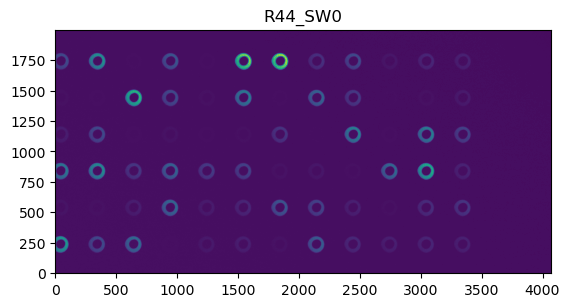

In [53]:
import matplotlib.pyplot as plt 
plt.imshow(exposure_extra.image.array,origin='lower' )#vmax=200)
plt.title(exposure_extra.getDetector().getName())

In [5]:
def calculateSN(stamp,sourceErosionIter=1, bkgDilationIter=10):
        """
        Calculate signal-to-noise ratio.

        Parameters
        ----------
        stamp : lsst.ts.wep.task.donutStamp
            A stamp containing donut image.


        Returns
        -------
        dict
             A dictionary of calculated quantities:
            'SN': the signal to noise ratio
            'signal': the calculated signal
            'noise': the calculated noise
        """

        #stamp.makeMask(instConfigFile, self.opticalModel)
        stamp_mask = stamp.stamp_im.mask.array
        image = stamp.stamp_im.image.array
        variance = stamp.stamp_im.variance.array

        donut_mask = stamp.stamp_im.mask.array > 0
    
         # Number of pixels taken by the donut in the original donut mask
        n_px_mask = np.sum(donut_mask)
    
         # Signal estimate based on the donut mean
        signal_mean = image[donut_mask].mean()  # per pixel
        ttl_signal_mean = n_px_mask * signal_mean
    
         # Signal estimate based on the sum of donut pixels
        ttl_signal_sum = np.sum(image[donut_mask])
    
         # Background noise estimate:
         # expand the inverted mask to remove donut contribution
        bkgnd_mask = ~binary_dilation(donut_mask, iterations=bkgDilationIter)
        background_image_stdev = image[bkgnd_mask].std()  # per pixel
        sqrt_mean_variance = np.sqrt(np.mean(variance[bkgnd_mask]))


     # Per-pixel variance based on the image region
         # outside of the dilated donut mask
        background_image_variance = image[bkgnd_mask].var()

         # The mean image value  in the background region
        background_image_mean = np.mean(image[bkgnd_mask])

         # Total noise based on the variance of the image background
        ttl_noise_bkgnd_variance = np.sqrt(background_image_variance * n_px_mask)

         # Noise based on the sum of variance plane pixels inside the donut mask
        ttl_noise_donut_variance = np.sqrt(variance[donut_mask].sum())
        sn = 0

        if ttl_noise_donut_variance > 0:
             sn = ttl_signal_sum / ttl_noise_donut_variance

        sn_dic = {
             "SN": sn,
             "signal_mean": ttl_signal_mean,
             "signal_sum": ttl_signal_sum,
             "n_px_mask": n_px_mask,
             "background_image_stdev": background_image_stdev,
             "sqrt_mean_variance": sqrt_mean_variance,
             "background_image_variance": background_image_variance,
             "background_image_mean": background_image_mean,
             "ttl_noise_bkgnd_variance": ttl_noise_bkgnd_variance,
             "ttl_noise_donut_variance": ttl_noise_donut_variance,
         }
        return sn_dic

import scipy
import astropy.units as u
def calculate_entropy(stamp):
    d = stamp.stamp_im.image.array
    # these follow code from https://github.com/lsst-ts/ts_wep/blob/develop/python/lsst/ts/wep/donutImageCheck.py
    array1d = d.flatten()
    #entroThres = 3.5
    numOfBins = 256
    hist, edges = np.histogram(array1d, bins=numOfBins)
    
    # Square the distribution to magnify the difference in entropy
    imgEntropy = scipy.stats.entropy(hist**2)
    
    return imgEntropy, hist, edges, 

In [2]:
from scipy.ndimage import binary_dilation
import numpy as np 
donutExtra =  donutStampsExtra[0]
sn_dic = calculateSN(donutExtra)

NameError: name 'donutStampsExtra' is not defined

In [20]:
summary ={}

for key in sn_dic.keys():
    summary[key] = []
# also add other lists to store the needed info 
summary['mag'] = []
summary['entropy'] = [] 

for detExtra in  [191, 195, 199, 203 ]:
    
    donutStampsExtra = data[detExtra]['donutStampsExtra'] 
    donutCatalogExtra =  data[detExtra]['donutCatalogExtra']

    for i, (donutExtra, donutIntra) in enumerate(
            zip(donutStampsExtra, donutStampsIntra)):
    
        # S/N quantities based on extra-focal donut ... 
        sn_dic = calculateSN(donutExtra)
        for key in sn_dic.keys():
            summary[key].append(sn_dic[key])
        
        # storing the extra-focal donut magnitude 
        summary['mag'].append(donutCatalogExtra['mag'][i]) 

        # store the entropy 
        entr, hist, edge = calculate_entropy(donutExtra)
        summary['entropy'].append(entr)

In [21]:
summary.keys()

dict_keys(['SN', 'signal_mean', 'signal_sum', 'n_px_mask', 'background_image_stdev', 'sqrt_mean_variance', 'background_image_variance', 'background_image_mean', 'ttl_noise_bkgnd_variance', 'ttl_noise_donut_variance', 'mag', 'entropy'])

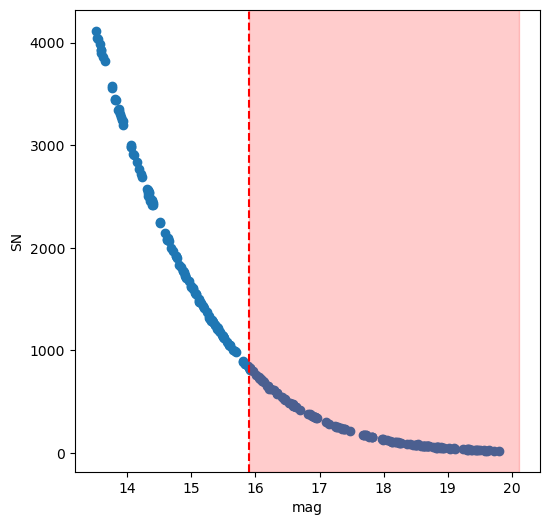

In [52]:
import matplotlib.pyplot as plt 
fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(summary['mag'], summary['SN'])
ax.set_xlabel('mag')
ax.set_ylabel('SN')
ax.axvline(15.90, ls='--', c='r')
ax.axvspan(15.9, xlims[1], alpha=0.2, color='red')


In [44]:
ax.get_xlim()

(13.185693788788347, 20.324490771962452)

In [46]:
 ax.get_ylim()

(1.8246754369072515, 5.0395024023139054)

(1.8316339368323742, 4.8933739038863315)

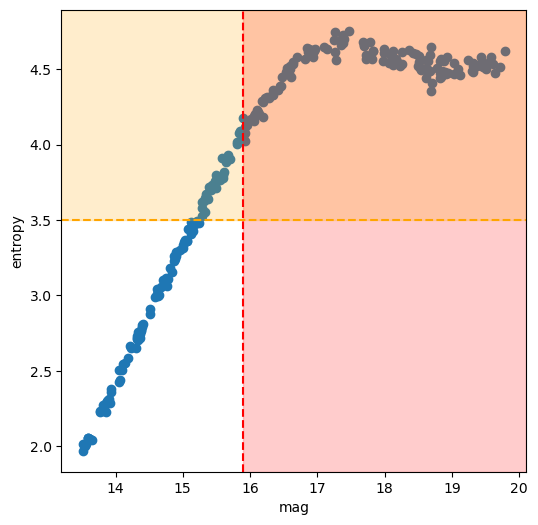

In [50]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(summary['mag'], summary['entropy'])
ax.set_xlabel('mag')
ax.set_ylabel('entropy')

xlims = ax.get_xlim()
ylims = ax.get_ylim()

ax.axvline(15.90, ls='--', c='r')
ax.axvspan(15.9, xlims[1], alpha=0.2, color='red')

ax.axhline(3.5, ls='--', c='orange')
ax.axhspan(3.5,  ylims[1], alpha=0.2, color='orange')
ax.set_xlim(xlims)
ax.set_ylim(ylims)

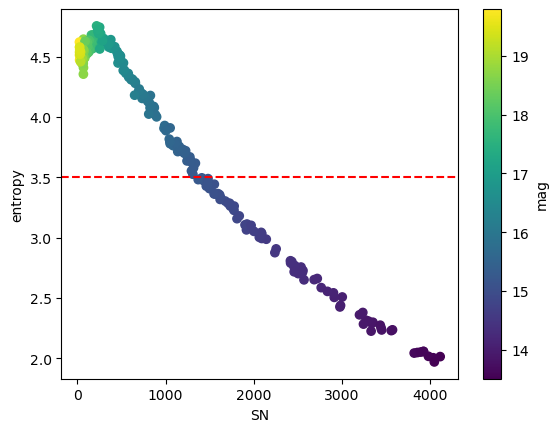

In [30]:
plt.scatter(summary['SN'], summary['entropy'],c=summary['mag'])
plt.xlabel('SN')
plt.ylabel('entropy')
plt.colorbar(label='mag')
plt.axhline(3.5,c='r', ls='--')

In [54]:
wfs_grid = summary

Compare to identical calculation on LsstCam FAM simulation

In [60]:
import lsst.daf.butler as dafButler
import os
import astropy.units as u


path_cwd = '/sdf/data/rubin/shared/scichris/DM-41957_lsstCam_sweep/'
butlerRootPath = os.path.join(path_cwd, 'gen3repo')
butler = dafButler.Butler(butlerRootPath)
collection = 'runFAM_960_962_d_2024_05_06_bps_all_science_var_SN'
registry = butler.registry
datasetRefs = registry.queryDatasets("donutStampsExtra",collections=[collection],
              where=f"instrument='LSSTCam'").expanded()
refs = []
for ref in datasetRefs:
    #print(ref)
    refs.append(ref)

#
summary ={}

for key in sn_dic.keys():
    summary[key] = []
# also add other lists to store the needed info 
summary['mag'] = []
summary['entropy'] = [] 

# go over all detectors 
for ref in refs:
    data_id_extra = ref.dataId
    print(data_id_extra)
    donutStampsExtra = butler.get("donutStampsExtra", dataId=data_id_extra, collections=[collection])
    if len(donutStampsExtra)>0:
      donutCatalogExtra = butler.get("donutCatalog", dataId=data_id_extra, collections=[collection])
      # add all magnitudes 
      mags = (donutCatalogExtra['source_flux'].values * u.nJy).to_value(u.ABmag)
      summary['mag'].extend(mags)
      for i, (donutExtra, donutIntra) in enumerate(
        zip(donutStampsExtra, donutStampsIntra)):

            # calculate just for extra-focal donut 
            sn_dic = calculateSN(donutExtra)
            for key in sn_dic.keys():
                summary[key].append(sn_dic[key])
                
            # store the entropy 
            entr, hist, edge = calculate_entropy(donutExtra)
            summary['entropy'].append(entr)

{instrument: 'LSSTCam', detector: 0, visit: 5028081800962, band: 'z', physical_filter: 'z_20'}
{instrument: 'LSSTCam', detector: 1, visit: 5028081800962, band: 'z', physical_filter: 'z_20'}
{instrument: 'LSSTCam', detector: 2, visit: 5028081800962, band: 'z', physical_filter: 'z_20'}
{instrument: 'LSSTCam', detector: 3, visit: 5028081800962, band: 'z', physical_filter: 'z_20'}
{instrument: 'LSSTCam', detector: 4, visit: 5028081800962, band: 'z', physical_filter: 'z_20'}
{instrument: 'LSSTCam', detector: 5, visit: 5028081800962, band: 'z', physical_filter: 'z_20'}
{instrument: 'LSSTCam', detector: 6, visit: 5028081800962, band: 'z', physical_filter: 'z_20'}
{instrument: 'LSSTCam', detector: 7, visit: 5028081800962, band: 'z', physical_filter: 'z_20'}
{instrument: 'LSSTCam', detector: 8, visit: 5028081800962, band: 'z', physical_filter: 'z_20'}
{instrument: 'LSSTCam', detector: 9, visit: 5028081800962, band: 'z', physical_filter: 'z_20'}
{instrument: 'LSSTCam', detector: 10, visit: 50280

We plot in blue the results for lsstCam FAM simulation involving all 189 detectors, overplotting in orange the wfs grid results. Although wfs grid was in a different band, there is a  qualitative  agreement. We mark with vertical dashed line the z-band magnitude limit for WFS in https://github.com/lsst-ts/ts_wep/blob/develop/policy/magLimitStar.yaml

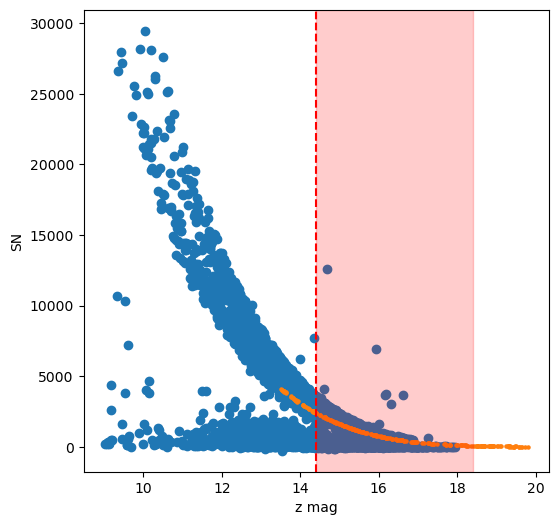

In [69]:
import matplotlib.pyplot as plt 
fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(summary['mag'], summary['SN'])
ax.scatter(wfs_grid['mag'], wfs_grid['SN'], s=5)
ax.set_xlabel('z mag')
ax.set_ylabel('SN')
ax.axvline(14.39, ls='--', c='r')
ax.axvspan(14.39, xlims[1], alpha=0.2, color='red')


(-0.03628199299206586, 5.670284703121732)

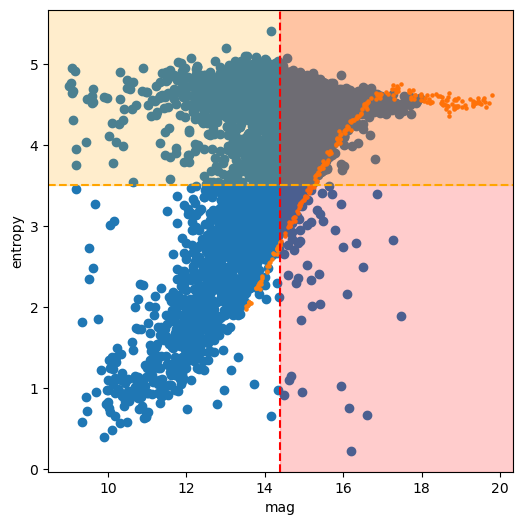

In [73]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(summary['mag'], summary['entropy'])
ax.scatter(wfs_grid['mag'], wfs_grid['entropy'],s=5)
#wfs_grid
ax.set_xlabel('mag')
ax.set_ylabel('entropy')

xlims = ax.get_xlim()
ylims = ax.get_ylim()

ax.axvline(14.390, ls='--', c='r')
ax.axvspan(14.39, xlims[1], alpha=0.2, color='red')

ax.axhline(3.5, ls='--', c='orange')
ax.axhspan(3.5,  ylims[1], alpha=0.2, color='orange')
ax.set_xlim(xlims)
ax.set_ylim(ylims)

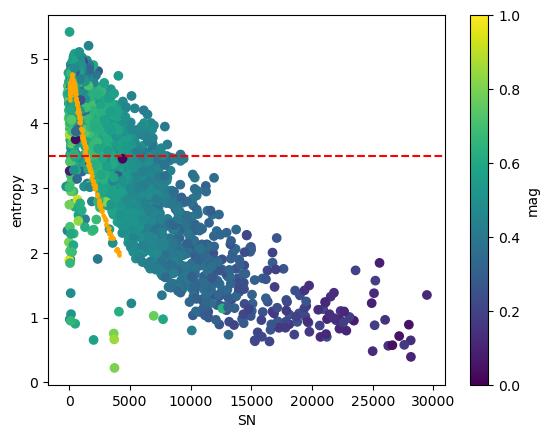

In [75]:
plt.scatter(summary['SN'], summary['entropy'],c=summary['mag'])
plt.scatter(wfs_grid['SN'], wfs_grid['entropy'],c='orange',s=5)
plt.xlabel('SN')
plt.ylabel('entropy')
plt.colorbar(label='mag')
plt.axhline(3.5,c='r', ls='--')

Show the wfs grid results for different bands. I run the same slurm file as for wfs_grid4, but set a different filter (`u,g,r,i,z,y` explicitly), and use the latest cvmfs   `2024_20`:

Based on  /sdf/group/rubin/shared/scichris/DM-43524_grid/runSlurm-wfs_test.sl

make appropriate slurm files :



In [137]:
def get_slurm_content(band,path_cwd, weekly="w_2024_21", sim = 6):
    slurm_log = f'wfs_grid_slurm_log{sim}{band}.sl'
    imsim_log = f'wfs_grid_imsim_log{sim}{band}.txt'
    path_slurm_log = os.path.join(path_cwd, slurm_log)
    path_imsim_log = os.path.join(path_cwd, imsim_log)
    
    path_output = os.path.join(path_cwd,f'wfs_grid{sim}{band}/')
    content = ['#!/bin/bash -l \n',
    '#SBATCH --partition milano \n',
    '#SBATCH --account rubin:developers \n',
    '#SBATCH --nodes 1 \n',
    '#SBATCH --mem=50G \n',
    '#SBATCH --cpus-per-task=80 \n',
    '#SBATCH -t 200:00:00 \n',
    f'#SBATCH --job-name w{sim}{band} \n',
    f'#SBATCH --output={path_slurm_log} \n',
    'echo "starting at `date` on `hostname`\n"' ,
    'pwd \n',


    f'source /cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/{weekly}/loadLSST-ext.bash \n',
    'setup lsst_distrib -t w_latest \n',
    
    'export IMSIM_HOME=/sdf/home/s/scichris/link_to_scichris/WORK/imsim_home \n',
    'export RUBIN_SIM_DATA_DIR=$IMSIM_HOME/rubin_sim_data \n',
    'export SIMS_SED_LIBRARY_DIR=$IMSIM_HOME/rubin_sim_data/sims_sed_library \n',
    'setup -k -r $IMSIM_HOME/imSim \n',
    'setup -k -r $IMSIM_HOME/skyCatalogs \n',
    'source  /sdf/data/rubin/user/scichris/WORK/aos_packages/setup_aos.sh  \n',
    
    f'python /sdf/data/rubin/user/scichris/WORK/aos_packages/ts_imsim/bin.src/img_closed_loop.py \
    --num_proc 50 --log_level 10 \
    --iter_num 5 --inst lsst  --imsim_log_file {path_imsim_log} \
    --output {path_output} \
    --sky_file /sdf/group/rubin/shared/scichris/DM-43524_grid/lsstCam_grid_random2.txt  --clobber \
    --pipeline_file /sdf/group/rubin/shared/scichris/DM-43524_grid/lsstPipelineCustomDoVar.yaml \
    --filter_type {band} \n',
    
    'echo "ended at `date` on `hostname`" \n']
    return content

In [84]:
band='u'
path_cwd = '/sdf/group/rubin/shared/scichris/DM-43524_grid/'
get_slurm_content(band,path_cwd)

['#!/bin/bash -l \n',
 '#SBATCH --partition milano \n',
 '#SBATCH --account rubin:developers \n',
 '#SBATCH --nodes 1 \n',
 '#SBATCH --mem=50G \n',
 '#SBATCH --cpus-per-task=80 \n',
 '#SBATCH -t 200:00:00 \n',
 '#SBATCH --job-name w5u \n',
 '#SBATCH --output=/sdf/group/rubin/shared/scichris/DM-43524_grid/wfs_grid_slurm_log5u.sl \n',
 'echo "starting at `date` on `hostname`\n"',
 'pwd \n',
 'source /cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2024_20/loadLSST-ext.bash \n',
 'setup lsst_distrib -t w_latest \n',
 'export IMSIM_HOME=/sdf/home/s/scichris/link_to_scichris/WORK/imsim_home \n',
 'export RUBIN_SIM_DATA_DIR=$IMSIM_HOME/rubin_sim_data \n',
 'export SIMS_SED_LIBRARY_DIR=$IMSIM_HOME/rubin_sim_data/sims_sed_library \n',
 'setup -k -r $IMSIM_HOME/imSim \n',
 'setup -k -r $IMSIM_HOME/skyCatalogs \n',
 'source  /sdf/data/rubin/user/scichris/WORK/aos_packages/setup_aos.sh  \n',
 'python /sdf/data/rubin/user/scichris/WORK/aos_packages/ts_imsim/bin.src/img_closed_loop.py     --num_proc 5

In [136]:
def write_to_file(out_file, content):
    with open(out_file, "w") as output:
        for line in content:
            output.write(line)
path_cwd = '/sdf/group/rubin/shared/scichris/DM-43524_grid/'
for band in 'ugrizy': 
    content = get_slurm_content(band, path_cwd)
    slurm_file_path = os.path.join(path_cwd, f'runSlurm-wfs_test_{band}.sl')
    print(f'Saved as {slurm_file_path}')
    write_to_file(slurm_file_path, content)

Saved as /sdf/group/rubin/shared/scichris/DM-43524_grid/runSlurm-wfs_test_u.sl
Saved as /sdf/group/rubin/shared/scichris/DM-43524_grid/runSlurm-wfs_test_g.sl
Saved as /sdf/group/rubin/shared/scichris/DM-43524_grid/runSlurm-wfs_test_r.sl
Saved as /sdf/group/rubin/shared/scichris/DM-43524_grid/runSlurm-wfs_test_i.sl
Saved as /sdf/group/rubin/shared/scichris/DM-43524_grid/runSlurm-wfs_test_z.sl
Saved as /sdf/group/rubin/shared/scichris/DM-43524_grid/runSlurm-wfs_test_y.sl


Check the queue:

    squeue -u scichris
    sbatch /sdf/group/rubin/shared/scichris/DM-43524_grid/runSlurm-wfs_test_u.sl


Check the progress:

    more /sdf/group/rubin/shared/scichris/DM-43524_grid/wfs_grid_slurm_log5u.sl 
    more /sdf/group/rubin/shared/scichris/DM-43524_grid/wfs_grid_imsim_log5u.txt



Note:  this   (`wfs_grid5_ugriz`)  was using:
* `imSim` :  `v2.0.0`, the latest commit `7237452fdce9` from March 18th,
* `skyCatalogs`: ` v1.6.0rc2`  with `ce81bb8` from Aug 14th
* `Galsim`: `v2.5.1`  commit `ea0f82baaa` from Nov 7th


Updated (for `wfs_grid6_ugriz` ):  

* `imSim`: `v2.0.0`, latest commit `d580f71f` from May 23
* `skyCatalogs`: branch `main`, tag `v1.7.0rc4`, commit `e6b60f3d26` from May 16
* `Galsim` : `v2.5.2`, commit `df8a639d5` from May 9th



In [ ]:
from lsst.ts.wep.utils import readConfigYaml

entroThresh=3.5
# reading 
# https://github.com/lsst-ts/ts_wep/blob/develop/policy/magLimitStar.yaml 
magPolicyDefaults = readConfigYaml("policy:magLimitStar.yaml")
filter = exposure_extra.info.getFilter()
defaultFilterKey = f"filter{filter.bandLabel.upper()}"
magMax = magPolicyDefaults[defaultFilterKey]["high"]
magMin = magPolicyDefaults[defaultFilterKey]["low"]

Run the simulation but I'm getting an error: 

      File "/sdf/data/rubin/user/scichris/WORK/aos_packages/ts_wep/python/lsst/ts/wep/task/calcZernikesTask.py", line 202, in run
    donutsExtraQuality = Table(
                         ^^^^^^
      raise ValueError(f"Inconsistent data column lengths: {lengths}")
ValueError: Inconsistent data column lengths: {66, 63}

eg 

         more /sdf/group/rubin/shared/scichris/DM-43524_grid/wfs_grid_slurm_log5u.sl 


Try to see if there's even the raw or postISR data in the butler: 

In [2]:
import lsst.daf.butler as dafButler
import os
path_cwd = '/sdf/group/rubin/shared/scichris/DM-43524_grid/wfs_grid5u'
butlerRootPath = os.path.join(path_cwd, 'imsimData')
butler = dafButler.Butler(butlerRootPath)
registry = butler.registry

In [5]:
#registry.queryCollections()

In [2]:
collection = 'ts_imsim_1000'
datasetRefs = registry.queryDatasets("donutStampsExtra",collections=[collection],
              where=f"instrument='LSSTCam'").expanded()
refs = []
for ref in datasetRefs:
    print(ref)

donutStampsExtra@{instrument: 'LSSTCam', detector: 191, visit: 7023062001000, band: 'u', day_obs: 20230620, physical_filter: 'u_24'} [sc=StampsBase] (run=ts_imsim_1000 id=257ece9b-9d41-4676-bdb4-16e531b2fdda)
donutStampsExtra@{instrument: 'LSSTCam', detector: 195, visit: 7023062001000, band: 'u', day_obs: 20230620, physical_filter: 'u_24'} [sc=StampsBase] (run=ts_imsim_1000 id=57bbbf16-0f98-415e-97b3-2765fb1adbe0)
donutStampsExtra@{instrument: 'LSSTCam', detector: 199, visit: 7023062001000, band: 'u', day_obs: 20230620, physical_filter: 'u_24'} [sc=StampsBase] (run=ts_imsim_1000 id=4d85ad86-7289-48bc-a80e-c876adf5c8ab)
donutStampsExtra@{instrument: 'LSSTCam', detector: 203, visit: 7023062001000, band: 'u', day_obs: 20230620, physical_filter: 'u_24'} [sc=StampsBase] (run=ts_imsim_1000 id=11a5b3db-2db2-4f4f-a74b-8162b60f9200)


In [3]:
data_id_extra = ref.dataId
donutStampsExtra = butler.get("donutStampsExtra", dataId=data_id_extra, collections=[collection])

In [4]:
donutStampsIntra = butler.get("donutStampsIntra", dataId=data_id_extra, collections=[collection])

In [5]:
len(donutStampsExtra)

66

In [6]:
len(donutStampsIntra)

63

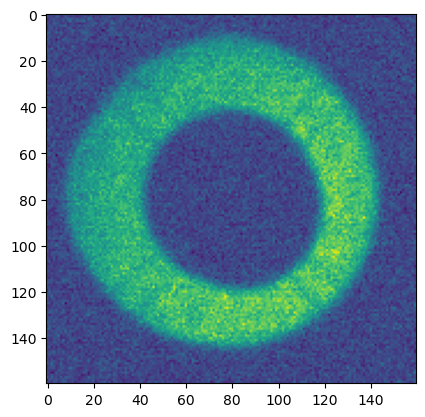

In [7]:
import matplotlib.pyplot as plt
plt.imshow(donutStampsExtra[20].stamp_im.image.array)

In [8]:
list(donutStampsExtra.metadata)

['SIMPLE',
 'BITPIX',
 'NAXIS',
 'EXTEND',
 'COMMENT',
 'RA_DEG',
 'DEC_DEG',
 'DET_NAME',
 'CAM_NAME',
 'DFC_TYPE',
 'DFC_DIST',
 'MAG',
 'CENT_X0',
 'CENT_Y0',
 'CENT_X',
 'CENT_Y',
 'CENT_DR',
 'BLEND_CX',
 'BLEND_CY',
 'X0',
 'Y0',
 'SN',
 'SIGNAL_MEAN',
 'SIGNAL_SUM',
 'NPX_MASK',
 'BKGD_STDEV',
 'SQRT_MEAN_VAR',
 'BKGD_VAR',
 'BACKGROUND_IMAGE_MEAN',
 'NOISE_VAR_BKGD',
 'NOISE_VAR_DONUT',
 'EFFECTIVE',
 'ENTROPY',
 'PEAK_HEIGHT',
 'BANDPASS',
 'HAS_MASK',
 'HAS_VARIANCE',
 'HAS_ARCHIVE',
 'N_STAMPS',
 'STAMPCLS',
 'VERSION',
 'ARCHIVE_IDS']

In [8]:
from lsst.ts.wep.task import (
    CalcZernikesTask,
    CalcZernikesTaskConfig,
    CombineZernikesMeanTask,
    CombineZernikesSigmaClipTask,
)
config = CalcZernikesTaskConfig()
calcTask = CalcZernikesTask(config=config, name="Base Task")


In [9]:
calcTask.run??

Object `calcTask.run` not found.


In [9]:
import numpy as np
snExtra = np.asarray(donutStampsExtra.metadata.getArray("SN"))

In [10]:
snExtra

array([1637.75646973, 1573.70837402, 1376.25476074, 1274.63415527,
       1129.97509766, 1078.51257324,  983.71069336,  961.96520996,
        948.17932129,  830.06848145,  798.88568115,  801.85150146,
        771.22680664,  753.35449219,  698.57537842,  657.30450439,
        647.69219971,  558.53173828,  552.7800293 ,  566.84796143,
        567.80993652,  491.53970337,  495.76766968,  484.38638306,
        418.55334473,  413.39343262,  383.45965576,  388.49993896,
        373.65673828,  319.16897583,  288.62985229,  244.65168762,
        227.87472534,  222.91142273,  213.26348877,  207.40898132,
        188.7321167 ,  183.14779663,  167.77363586,  153.02723694,
        159.78311157,  144.96173096,  130.44378662,  116.03755951,
         96.82231903,   72.49230957,   75.59397125,   39.1893692 ,
         29.9441967 ,   33.52620697,   31.56871796,   25.37360954,
         12.88724327,   19.42548943,   18.93695831,   16.93129349,
         12.60510826,    4.05599499,    1.71151567,    5.38651

In [11]:
struct = calcTask.run(donutStampsIntra, donutStampsExtra
        )

INFO:CombineZernikesSigmaClipTask:Using 38 pairs out of 63 in final Zernike estimate.


In [12]:
struct.donutsIntraQuality

SN   ENTROPY  ENTROPY_SELECT  SN_SELECT  FINAL_SELECT
0   1637.756470  3.048420            True       True          True
1   1573.708374  3.081004            True       True          True
2   1376.254761  3.347433            True       True          True
3   1274.634155  3.394946            True       True          True
4   1129.975098  3.593368            True       True          True
..          ...       ...             ...        ...           ...
61     4.683892  4.449262            True       True          True
62     5.820813  4.494766            True       True          True
63     2.187686  4.447124            True       True          True
64    -4.228501  4.533892            True       True          True
65     3.356041  4.446744            True       True          True

[66 rows x 5 columns]

Try running it step by step to find out what's going on:

In [16]:
selectWithEntropy = False
selectWithSignalToNoise = False
maxEntropy = 3.5
minSignalToNoise = 3500
# Which donuts to use for Zernike estimation
# initiate these by selecting all donuts
entropySelectExtra = np.ones(len(donutStampsExtra), dtype="bool")
entropySelectIntra = np.ones(len(donutStampsIntra), dtype="bool")
entropyExtra = np.zeros(len(donutStampsExtra))
entropyIntra = np.zeros(len(donutStampsIntra))
print(len(entropyExtra))
print(len(entropyIntra))
if selectWithEntropy:
    entropyExtra = np.asarray(donutStampsExtra.metadata.getArray("ENTROPY"))
    entropyIntra = np.asarray(donutStampsIntra.metadata.getArray("ENTROPY"))
    entropySelectExtra = entropyExtra < self.maxEntropy
    entropySelectIntra = entropyIntra < self.maxEntropy

snSelectExtra = np.ones(len(donutStampsExtra), dtype="bool")
snSelectIntra = np.ones(len(donutStampsIntra), dtype="bool")
snExtra = np.zeros(len(donutStampsExtra))
snIntra = np.zeros(len(donutStampsIntra))
if selectWithSignalToNoise:
    snExtra = np.asarray(donutStampsExtra.metadata.getArray("SN"))
    snSelectExtra = minSignalToNoise < snExtra

    snIntra = np.asarray(donutStampsIntra.metadata.getArray("SN"))
    snSelectIntra = minSignalToNoise < snIntra

66
63


Given that the stamps are accessible and they have the metadata, calculate entropy and get the SN directly from stamps. Store for future access since the kernel keeps dying ... 

In [1]:
import os

In [50]:
import lsst.daf.butler as dafButler
import os
import astropy.units as u
import numpy as np 

collection = 'ts_imsim_1000' 
data = {}

for  band in 'ugriz':
    path_cwd = f'/sdf/group/rubin/shared/scichris/DM-43524_grid/wfs_grid5{band}'
    butlerRootPath = os.path.join(path_cwd, 'imsimData')
    butler = dafButler.Butler(butlerRootPath)
    data[band] = {}

    for detExtra in  [191, 195, 199, 203 ]:
        print(band, detExtra)
        data[band][detExtra] = {}
        dataIdExtra = {'instrument': 'LSSTCam', 'detector': detExtra, 'exposure': 7023062001000, 'visit':7023062001000}
        dataIdIntra = {'instrument': 'LSSTCam', 'detector': detExtra+1, 'exposure': 7023062001000, 'visit':7023062001000}
        data[band][detExtra]['dataIdExtra']=dataIdExtra
        data[band][detExtra]['dataIdIntra']=dataIdIntra
        
        exposure_extra = butler.get('postISRCCD', dataId=dataIdExtra, collections=[collection])
        data[band][detExtra]['exposure_extra'] = exposure_extra
        
        # print(exposure_extra.getDetector().getName())
        donutStampsExtra = butler.get('donutStampsExtra', 
                                  dataId=dataIdExtra, 
                                  collections=[collection])  
        
        donutStampsIntra = butler.get('donutStampsIntra', 
                                  dataId=dataIdExtra, 
                                  collections=[collection])  
        data[band][detExtra]['donutStampsExtra'] = donutStampsExtra
        data[band][detExtra]['donutStampsIntra'] = donutStampsIntra
        
        
        donutCatalogExtra = butler.get('donutCatalog', 
                                  dataId=dataIdExtra, 
                                  collections=[collection])  
        
        donutCatalogIntra = butler.get('donutCatalog', 
                                  dataId=dataIdIntra, 
                                  collections=[collection]) 
         # calculate the AB magnitudes 
        donutCatalogExtra['mag'] = (donutCatalogExtra['source_flux'].values * u.nJy).to_value(u.ABmag)
        donutCatalogIntra['mag'] = (donutCatalogIntra['source_flux'].values * u.nJy).to_value(u.ABmag)
    
        data[band][detExtra]['donutCatalogExtra'] = donutCatalogExtra
        data[band][detExtra]['donutCatalogIntra'] = donutCatalogIntra

        # Store each dic per band as a pickle for quicker access ... 
        np.save(f'wfs_grid5_ugriz_exposure_donuts_catalogs{band}', data[band], )
     

u 191
u 195
u 199
u 203
g 191
g 195
g 199
g 203
r 191
r 195
r 199
r 203
i 191
i 195
i 199
i 203
z 191
z 195
z 199
z 203


Store that to make the data access quicker:

In [8]:
from scipy.ndimage import binary_dilation
donutExtra =  donutStampsExtra[0]
sn_dic = calculateSN(donutExtra)

In [9]:
summary = {}
for band in data.keys():
    summary[band] = {}
    summary[band]['mag'] = []
    summary[band]['entropy'] = [] 
    
    for key in sn_dic.keys():
        summary[band][key] = []
# also add other lists to store the needed info 
#summary[band]['mag'] = []
#summary[band]['entropy'] = [] 

Store the summary dic (just in  case the kernel dies again... ) :

In [27]:
data.keys()

dict_keys(['u', 'g', 'r', 'i', 'z'])

In [18]:
for band in data.keys():
    for detExtra in data[band].keys() :
        
        donutStampsExtra = data[band][detExtra]['donutStampsExtra'] 
        donutCatalogExtra =  data[band][detExtra]['donutCatalogExtra']
    
        for i, (donutExtra, donutIntra) in enumerate(
                zip(donutStampsExtra, donutStampsIntra)):
        
            # S/N quantities based on extra-focal donut ... 
            sn_dic = calculateSN(donutExtra)
            for key in sn_dic.keys():
                summary[band][key].append(sn_dic[key])
            
            # storing the extra-focal donut magnitude 
            summary[band]['mag'].append(donutCatalogExtra['mag'][i]) 
    
            # store the entropy 
            entr, hist, edge = calculate_entropy(donutExtra)
            summary[band]['entropy'].append(entr)
            
np.save('wfs_grid5_ugriz_summary_dic', summary,allow_pickle=True,)#clobber=True)

In [131]:
# that summary file contains all the info that I need for the plots below; 
# if kernel dies, can re-read it here


summary = np.load('wfs_grid5_ugriz_summary_dic.npy', allow_pickle=True).item()

In [22]:
#summary['u']

In [24]:
from lsst.ts.wep.utils import readConfigYaml

entroThresh=3.5
# reading 
# https://github.com/lsst-ts/ts_wep/blob/develop/policy/magLimitStar.yaml 
magPolicyDefaults = readConfigYaml("policy:magLimitStar.yaml")
filter = exposure_extra.info.getFilter()
defaultFilterKey = f"filter{filter.bandLabel.upper()}"
magMax = magPolicyDefaults[defaultFilterKey]["high"]
magMin = magPolicyDefaults[defaultFilterKey]["low"]

In [26]:
defaultFilterKey

'filterR'

In [24]:
summary.keys()

dict_keys(['u', 'g', 'r', 'i', 'z'])

In [118]:
from lsst.ts.wep.utils import readConfigYaml

# reading 
# https://github.com/lsst-ts/ts_wep/blob/develop/policy/magLimitStar.yaml 
magPolicyDefaults = readConfigYaml("policy:magLimitStar.yaml")

In [33]:
magPolicyDefaults

{'filterU': {'low': 7.35, 'high': 14.96},
 'filterG': {'low': 8.74, 'high': 15.9},
 'filterR': {'low': 8.52, 'high': 15.42},
 'filterI': {'low': 8.23, 'high': 14.97},
 'filterZ': {'low': 7.83, 'high': 14.39},
 'filterY': {'low': 7.04, 'high': 13.47}}

Text(0, 0.5, 'SN')

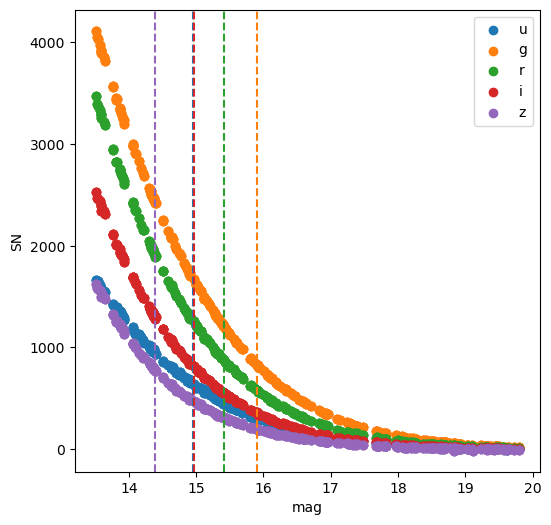

In [119]:
from matplotlib import colormaps as cmaps
import matplotlib.pyplot as plt 
from lsst.ts.wep.utils import readConfigYaml
#
#magMax = magPolicyDefaults[defaultFilterKey]["high"]

cmap = cmaps['tab10']

fig,ax = plt.subplots(1,1,figsize=(6,6))
i = 0 
for band in summary.keys() :
    ax.scatter(summary[band]['mag'], summary[band]['SN'], label=band, color=cmap(i))

    magMax = magPolicyDefaults[f'filter{band.upper()}']["high"]
    ax.axvline(magMax, ls='--', c=cmap(i))
    i += 1 
ax.legend()
xlims = ax.get_xlim()
ax.set_xlabel('mag')
ax.set_ylabel('SN')
#ax.axvline(15.90, ls='--', c='r')
#ax.axvspan(15.9, xlims[1], alpha=0.2, color='red')


(1.8303672125518051, 4.919975113778284)

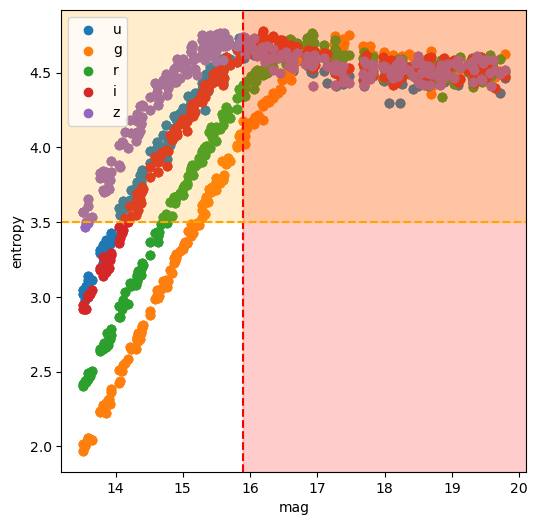

In [120]:
# entropy vs mag 
fig,ax = plt.subplots(1,1,figsize=(6,6))
for band in summary.keys() :
    ax.scatter(summary[band]['mag'], summary[band]['entropy'],label=band)
ax.set_xlabel('mag')
ax.set_ylabel('entropy')
ax.legend()
xlims = ax.get_xlim()
ylims = ax.get_ylim()

ax.axvline(15.90, ls='--', c='r')
ax.axvspan(15.9, xlims[1], alpha=0.2, color='red')

ax.axhline(3.5, ls='--', c='orange')
ax.axhspan(3.5,  ylims[1], alpha=0.2, color='orange')
ax.set_xlim(xlims)
ax.set_ylim(ylims)


In [38]:
cmap = cmaps['Pastel2']

In [42]:
cmap(0)

(0.7019607843137254, 0.8862745098039215, 0.803921568627451, 1.0)

In [43]:
cmap(1)

(0.9921568627450981, 0.803921568627451, 0.6745098039215687, 1.0)

In [44]:
cmap(10)

(0.8, 0.8, 0.8, 1.0)

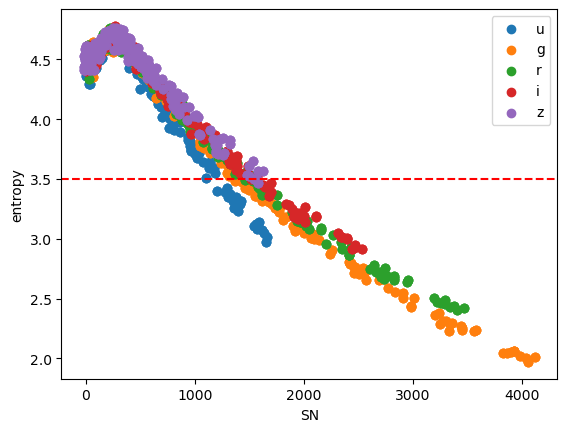

In [31]:
for band in summary.keys() :
    plt.scatter(summary[band]['SN'], summary[band]['entropy'],label=band)
plt.legend()
plt.xlabel('SN')
plt.ylabel('entropy')
#plt.colorbar(label='mag')
plt.axhline(3.5,c='r', ls='--')


--> why is u-band  getting a much lower SN than g or r-band ? 

--> show the stamps , etc... 

Show eg. stamps around mag 15 to see if it makes sense that a u-band at mag=15 gets much smaller SN... ?  

In [50]:
data['u'][191]['donutStampsExtra']

In [120]:
for band, row in enumerate('ugriz'):
    print(band, row)

0 u
1 g
2 r
3 i
4 z


In [134]:
for band in 'igruz':
    print(data[band][191]['donutCatalogExtra']['mag'][5:7])

5    14.056627
6    14.095882
Name: mag, dtype: float64
5    14.056627
6    14.095882
Name: mag, dtype: float64
5    14.056627
6    14.095882
Name: mag, dtype: float64
5    14.056627
6    14.095882
Name: mag, dtype: float64
5    14.056627
6    14.095882
Name: mag, dtype: float64


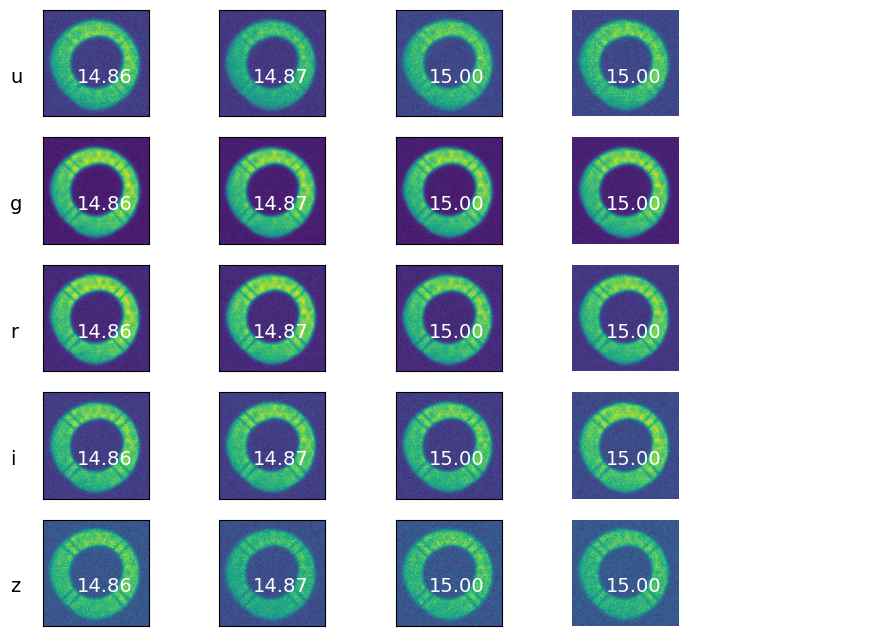

In [130]:
ncols=5
nrows=5
fig,axs = plt.subplots(nrows,ncols, figsize=(11,8))

row = 0
for row, band in enumerate('ugriz'):
    mag = data[band][191]['donutCatalogExtra']['mag']
    fullstamps = np.ravel(data[band][191]['donutStampsExtra'])

    selection = abs(mag-15)<0.2
    mask = selection.values
    if np.sum(mask) > 0:
        donuts = fullstamps[selection]
        
        ndonuts = len(donuts)
        axs[row,0].text(-50,50, band, fontsize=14)
        for i in range(ndonuts): #len(donutStampsExtra)):
            axs[row,i].imshow(donuts[i].stamp_im.image.array, origin='lower')
            axs[row,i].text(50,50, f'{mag[selection].values[i]:.2f}',
                            c='white', fontsize=14)
            axs[row,i].set_xticks([])
            axs[row,i].set_yticks([])
       
        if ndonuts < ncols:
            for j in range(i,ncols):
                axs[row,j].axis('off')

In [127]:
mag[selection].values[0]

14.863853126198265

In [67]:
selection = abs(mag-15)<0.2
mag[selection].index.values

array([18, 19, 20, 21])

In [87]:
idx = np.array(mag[selection].index.values).astype(int)

In [95]:
fullstamps = np.ravel(data['u'][191]['donutStampsExtra'])

In [96]:
type(fullstamps)

numpy.ndarray

In [97]:
donuts = fullstamps[mask]

In [99]:
len(donuts)

4

In [73]:
mask

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

Consider what's the total signal per donut in the image ("signal_sum"  ) ,  and total noise ("ttl_noise_donut_variance"):  plot these 

In [140]:
summary['u'].keys()

dict_keys(['mag', 'entropy', 'SN', 'signal_mean', 'signal_sum', 'n_px_mask', 'background_image_stdev', 'sqrt_mean_variance', 'background_image_variance', 'background_image_mean', 'ttl_noise_bkgnd_variance', 'ttl_noise_donut_variance'])

Text(0, 0.5, 'Signal: $\\sum \\mathrm{image[donut]}$')

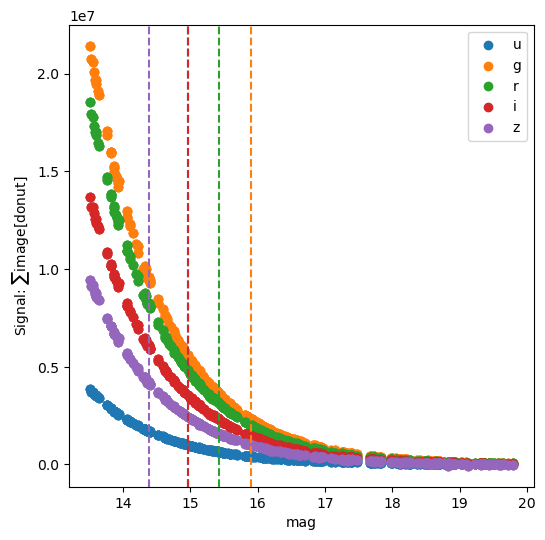

In [143]:
from matplotlib import colormaps as cmaps
import matplotlib.pyplot as plt 
from lsst.ts.wep.utils import readConfigYaml
#
#magMax = magPolicyDefaults[defaultFilterKey]["high"]

cmap = cmaps['tab10']

fig,ax = plt.subplots(1,1,figsize=(6,6))
i = 0 
for band in summary.keys() :
    ax.scatter(summary[band]['mag'], summary[band]['signal_sum'], label=band, color=cmap(i))

    magMax = magPolicyDefaults[f'filter{band.upper()}']["high"]
    ax.axvline(magMax, ls='--', c=cmap(i))
    i += 1 
ax.legend()
xlims = ax.get_xlim()
ax.set_xlabel('mag')
ax.set_ylabel('Signal: '+r'$\sum \mathrm{image[donut]}$')
#ax.axvline(15.90, ls='--', c='r')
#ax.axvspan(15.9, xlims[1], alpha=0.2, color='red')


Text(0, 0.5, 'Noise: $\\sqrt{\\sum \\mathrm{variance[donut]}}$')

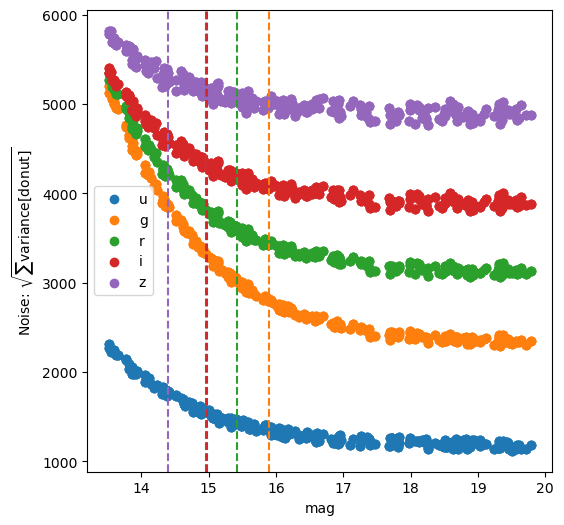

In [145]:
from matplotlib import colormaps as cmaps
import matplotlib.pyplot as plt 
from lsst.ts.wep.utils import readConfigYaml
#
#magMax = magPolicyDefaults[defaultFilterKey]["high"]

cmap = cmaps['tab10']

fig,ax = plt.subplots(1,1,figsize=(6,6))
i = 0 
for band in summary.keys() :
    ax.scatter(summary[band]['mag'], summary[band]['ttl_noise_donut_variance'], label=band, color=cmap(i))

    magMax = magPolicyDefaults[f'filter{band.upper()}']["high"]
    ax.axvline(magMax, ls='--', c=cmap(i))
    i += 1 
ax.legend()
xlims = ax.get_xlim()
ax.set_xlabel('mag')
ax.set_ylabel('Noise: '+r'$\sqrt{\sum \mathrm{variance[donut]}}$')
#ax.axvline(15.90, ls='--', c='r')
#ax.axvspan(15.9, xlims[1], alpha=0.2, color='red')


Text(0.5, 1.0, 'WCS-based')

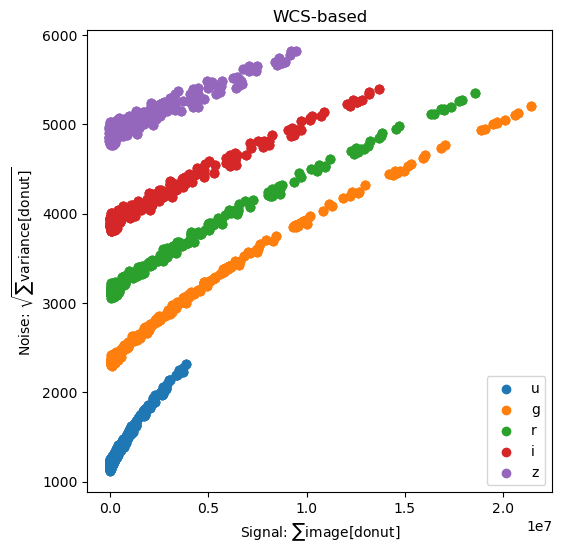

In [132]:
from matplotlib import colormaps as cmaps
import matplotlib.pyplot as plt 
from lsst.ts.wep.utils import readConfigYaml
#
#magMax = magPolicyDefaults[defaultFilterKey]["high"]

cmap = cmaps['tab10']

fig,ax = plt.subplots(1,1,figsize=(6,6))
i = 0 
for band in summary.keys() :
    ax.scatter( summary[band]['signal_sum'],summary[band]['ttl_noise_donut_variance'],  label=band, color=cmap(i))

    magMax = magPolicyDefaults[f'filter{band.upper()}']["high"]
    #ax.axvline(magMax, ls='--', c=cmap(i))
    i += 1 
ax.legend()
xlims = ax.get_xlim()

ax.set_xlabel('Signal: '+r'$\sum \mathrm{image[donut]}$')
ax.set_ylabel('Noise: '+r'$\sqrt{\sum \mathrm{variance[donut]}}$')
ax.set_title('WCS-based')
#ax.axvline(15.90, ls='--', c='r')
#ax.axvspan(15.9, xlims[1], alpha=0.2, color='red')





## Try rerunning WEP but use `generateDonutDirectDetect`  to get donut catalog and hence `source_flux` values:

In [ ]:
import lsst.daf.butler as dafButler
import os
import astropy.units as u
import numpy as np 

collection = 'ts_imsim_1000' 
data_exps = {}

for  band in 'ugriz':
    path_cwd = f'/sdf/group/rubin/shared/scichris/DM-43524_grid/wfs_grid5{band}'
    butlerRootPath = os.path.join(path_cwd, 'imsimData')
    butler = dafButler.Butler(butlerRootPath)
    data[band] = {}

    for detExtra in  [191, 195, 199, 203 ]:
        print(band, detExtra)
        data[band][detExtra] = {}
        dataIdExtra = {'instrument': 'LSSTCam', 'detector': detExtra, 'exposure': 7023062001000, 'visit':7023062001000}
        dataIdIntra = {'instrument': 'LSSTCam', 'detector': detExtra+1, 'exposure': 7023062001000, 'visit':7023062001000}
        data[band][detExtra]['dataIdExtra']=dataIdExtra
        data[band][detExtra]['dataIdIntra']=dataIdIntra
        
        exposure_extra = butler.get('postISRCCD', dataId=dataIdExtra, collections=[collection])
        data[band][detExtra]['exposure_extra'] = exposure_extra

        exposure_intra = butler.get('postISRCCD', dataId=dataIdIntra, collections=[collection])
        data[band][detExtra]['exposure_intra'] = exposure_intra

u 191
u 195
u 199
u 203
g 191
g 195
g 199
g 203
r 191
r 195
r 199
r 203
i 191
i 195
i 199
i 203
z 191
z 195


In [29]:
from lsst.ts.wep.task import GenerateDonutDirectDetectTask, GenerateDonutDirectDetectTaskConfig

config  = GenerateDonutDirectDetectTaskConfig()
detectTask = GenerateDonutDirectDetectTask(config=config)

config.donutSelector.useCustomMagLimit = True

from lsst.ts.wep.task.cutOutDonutsCwfsTask import  ( 
    CutOutDonutsCwfsTask, CutOutDonutsCwfsTaskConfig)



In [28]:
#registry.queryCollections()

In [15]:
registry = butler.registry
registry.queryDatasetTypes()

[DatasetType('cal_ref_cat', {htm7}, SimpleCatalog),
 DatasetType('raw', {band, instrument, day_obs, detector, group, physical_filter, exposure}, Exposure),
 DatasetType('camera', {instrument}, Camera, isCalibration=True),
 DatasetType('crosstalk', {instrument, detector}, CrosstalkCalib, isCalibration=True),
 DatasetType('transmission_sensor', {instrument, detector}, TransmissionCurve, isCalibration=True),
 DatasetType('calcZernikesTask_config', {}, Config),
 DatasetType('cutOutDonutsCwfsTask_config', {}, Config),
 DatasetType('generateDonutCatalogWcsTask_config', {}, Config),
 DatasetType('isr_config', {}, Config),
 DatasetType('isr_log', {band, instrument, day_obs, detector, group, physical_filter, exposure}, ButlerLogRecords),
 DatasetType('isr_metadata', {band, instrument, day_obs, detector, group, physical_filter, exposure}, TaskMetadata),
 DatasetType('postISRCCD', {band, instrument, day_obs, detector, group, physical_filter, exposure}, Exposure),
 DatasetType('donutCatalog', {ban

In [30]:
from lsst.ts.wep.task import (
GenerateDonutDirectDetectTask, GenerateDonutDirectDetectTaskConfig)

from lsst.ts.wep.task.cutOutDonutsCwfsTask import  ( 
    CutOutDonutsCwfsTask, CutOutDonutsCwfsTaskConfig)

import lsst.obs.lsst as obs_lsst


import lsst.daf.butler as dafButler
import os
import astropy.units as u
import numpy as np 

collection = 'ts_imsim_1000' 
camera = obs_lsst.LsstCam().getCamera()

config  = GenerateDonutDirectDetectTaskConfig()
config.donutSelector.useCustomMagLimit = True
config.measurementTask.nSigmaDetection = 5
detectTask = GenerateDonutDirectDetectTask(config=config)

results = {}
for band in 'ugriz':
    path_cwd = f'/sdf/group/rubin/shared/scichris/DM-43524_grid/wfs_grid5{band}'
    butlerRootPath = os.path.join(path_cwd, 'imsimData')
    butler = dafButler.Butler(butlerRootPath)
    results[band] = {}
    
    for detExtra in  [191, 195, 199, 203 ]:

        print(band, detExtra)
        results[band][detExtra] = {}
        dataIdExtra = {'instrument': 'LSSTCam', 'detector': detExtra, 'exposure': 7023062001000, 'visit':7023062001000}
        dataIdIntra = {'instrument': 'LSSTCam', 'detector': detExtra+1, 'exposure': 7023062001000, 'visit':7023062001000}
        results[band][detExtra]['dataIdExtra']=dataIdExtra
        results[band][detExtra]['dataIdIntra']=dataIdIntra
        
        exposure_extra = butler.get('postISRCCD', dataId=dataIdExtra, collections=[collection])
        results[band][detExtra]['exposure_extra'] = exposure_extra

        exposure_intra = butler.get('postISRCCD', dataId=dataIdIntra, collections=[collection])
        results[band][detExtra]['exposure_intra'] = exposure_intra

        
        #camera = butler.get('camera',  dataId=dataIdExtra, collections=['LSSTCam/raw/all'])
        
        # run donut detection 
        detectTask = GenerateDonutDirectDetectTask(config=config)
        structDetectExtra = detectTask.run(exposure_extra, camera)

        # does it make 
        #detectTask = GenerateDonutDirectDetectTask(config=config)
        structDetectIntra = detectTask.run(exposure_intra, camera)
        results[band][detExtra]['donutCatalogExtra'] = structDetectExtra.donutCatalog
        results[band][detExtra]['donutCatalogIntra'] = structDetectIntra.donutCatalog
    
        # run donut cutouts 
        cutoutConfig = CutOutDonutsCwfsTaskConfig()
        #cutoutConfig.donutStampSize = 160
        cutoutConfig.instConfigFile = 'policy:instruments/LsstCam.yaml'
        config.donutSelector.useCustomMagLimit = True
        cutoutTask = CutOutDonutsCwfsTask(config=cutoutConfig) 
        structCutouts = cutoutTask.run([exposure_extra, exposure_intra], 
                                       [structDetectExtra.donutCatalog, structDetectIntra.donutCatalog], 
                                       camera)
        results[band][detExtra]['donutStampsExtra'] = structCutouts.donutStampsExtra
        results[band][detExtra]['donutStampsIntra'] = structCutouts.donutStampsIntra

u 191


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 55 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 55 of 55 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 52/55 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 48 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 48 of 48 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 38/48 references


u 195


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 53 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 53 of 53 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 41/53 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 41 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 41 of 41 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 36/41 references


u 199


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 53 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 53 of 53 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 47/53 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 39 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 39 of 39 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 33/39 references


u 203


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 54 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 54 of 54 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 45/54 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 37 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 37 of 37 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 36/37 references


g 191


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 54 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 54 of 54 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 49/54 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 42 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 42 of 42 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 32/42 references


g 195


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 49 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 49 of 49 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 40/49 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 38 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 38 of 38 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 30/38 references


g 199


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 54 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 54 of 54 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 46/54 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 31 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 31 of 31 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 23/31 references


g 203


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 54 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 54 of 54 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 45/54 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 37 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 37 of 37 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 24/37 references


r 191


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 49 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 49 of 49 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 38/49 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 29 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 29 of 29 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 22/29 references


r 195


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 47 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 47 of 47 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 38/47 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 35 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 35 of 35 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 20/35 references


r 199


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 48 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 48 of 48 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 41/48 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 31 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 31 of 31 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 18/31 references


r 203


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 51 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 51 of 51 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 44/51 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 33 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 33 of 33 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 19/33 references


i 191


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 40 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 40 of 40 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 34/40 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 17 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 17 of 17 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 16/17 references


i 195


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 37 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 37 of 37 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 31/37 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 18 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 18 of 18 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 18/18 references


i 199


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 42 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 42 of 42 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 34/42 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 13 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 13 of 13 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 13/13 references


i 203


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 45 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 45 of 45 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 35/45 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 15 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 15 of 15 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 15/15 references


z 191


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 29 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 29 of 29 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 23/29 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 6 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 6 of 6 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 6/6 references


z 195


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 29 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 29 of 29 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 22/29 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 8 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 8 of 8 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 8/8 references


z 199


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 30 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 30 of 30 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 28/30 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 6 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 6 of 6 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 6/6 references


z 203


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 36 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 36 of 36 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 23/36 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 8 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 8 of 8 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 8/8 references


In [46]:
#np.save?

In [47]:
np.save('results_directDetect_alldets_ugriz', results)

# Fix donut direct detect error message:  DM-44529  

Created https://rubinobs.atlassian.net/browse/DM-44529 to deal with that... Eg do 


    if len(donutDf) > 0:
        donutDf[f"{bandLabel}_flux"] = donutDf["apFlux70"]
        # Run the donut selector task.
            if self.config.doDonutSelection:
                self.log.info("Running Donut Selector")
                donutSelection = self.donutSelector.run(
                    donutDf, exposure.detector, bandLabel
                )
                donutCatSelected = donutDf[donutSelection.selected].reset_index(drop=True)
                donutCatSelected["blend_centroid_x"] = donutSelection.blendCentersX
                donutCatSelected["blend_centroid_y"] = donutSelection.blendCentersY
            else:
                # if donut selector was not run,
                # set the required columns to be empty
                donutDf["blend_centroid_x"] = ""
                donutDf["blend_centroid_y"] = ""
                donutCatSelected = donutDf
    
            donutCatSelected.rename(
                columns={f"{bandLabel}_flux": "source_flux"}, inplace=True
            )
    
            # update column names and content
            donutCatUpd = self.updateDonutCatalog(donutCatSelected, exposure)
    
    else:
      log.message: "No donuts detected by quickMeasurementTask" 
      donutCatUpd = donutDf
    
    
    
    return pipeBase.Struct(donutCatalog=donutCatUpd)


Should it be 


    errMsg = "No donuts detected by quickMeasurementTask"
    raise ValueError(errMsg)


or  

    self.log.info("No donuts detected by ...")

 ?  


I think given that the `quickMeasurementTask` null results are at a log-level:

    INFO:lsst.donutQuickMeasurementTask:Found 0 sources in exposure
    INFO:lsst.donutQuickMeasurementTask:Measured 0 of 0 sources in exposure

the latter is more appropriate - it's not an error,  it's a result of detection (detecting nothing) . 


## [Aside]:  Try running quickMeasurementTask directly to debug why donuts are not detected

How is it that in the i-band  it's finding sources in the extra-focal  detector but not in the intra-focal ?  Plot these two exposures to check what's going on : 

In [4]:
import lsst.daf.butler as dafButler
import os
import astropy.units as u
import numpy as np 

collection = 'ts_imsim_1000' 
#results = {}
for band in 'i':
    path_cwd = f'/sdf/group/rubin/shared/scichris/DM-43524_grid/wfs_grid5{band}'
    butlerRootPath = os.path.join(path_cwd, 'imsimData')
    butler = dafButler.Butler(butlerRootPath)
    #results[band] = {}
    
    for detExtra in  [191]:#, 195, 199, 203 ]:

        print(band, detExtra)
        #results[band][detExtra] = {}
        dataIdExtra = {'instrument': 'LSSTCam', 'detector': detExtra, 'exposure': 7023062001000, 'visit':7023062001000}
        dataIdIntra = {'instrument': 'LSSTCam', 'detector': detExtra+1, 'exposure': 7023062001000, 'visit':7023062001000}
        #results[band][detExtra]['dataIdExtra']=dataIdExtra
        #results[band][detExtra]['dataIdIntra']=dataIdIntra
        
        exposure_extra = butler.get('postISRCCD', dataId=dataIdExtra, collections=[collection])
        #results[band][detExtra]['exposure_extra'] = exposure_extra

        exposure_intra = butler.get('postISRCCD', dataId=dataIdIntra, collections=[collection])
        #results[band][detExtra]['exposure_intra'] = exposure_intra

i 191


Text(0.5, 1.0, 'R00_SW0')

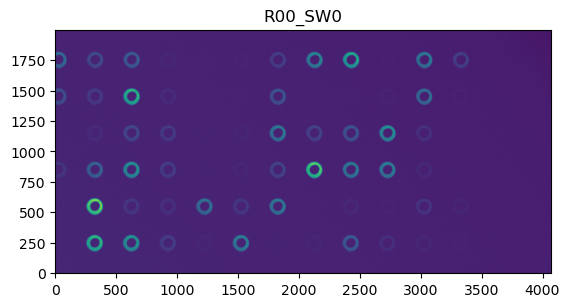

In [5]:
import matplotlib.pyplot as plt 
plt.imshow(exposure_extra.image.array,origin='lower' )#vmax=200)
plt.title(exposure_extra.getDetector().getName())

Text(0.5, 1.0, 'R00_SW1')

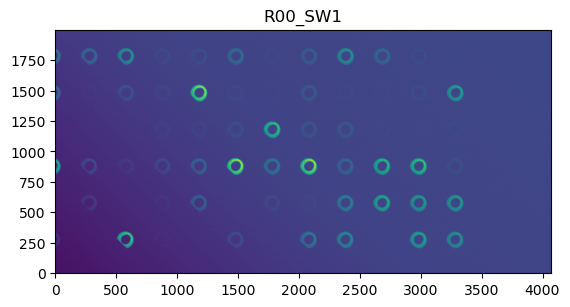

In [54]:

plt.imshow(exposure_intra.image.array,origin='lower' )#vmax=200)
plt.title(exposure_intra.getDetector().getName())

there are donuts! So what's going on ?  

In [151]:
config  = GenerateDonutDirectDetectTaskConfig()
config.donutSelector.useCustomMagLimit = True
detectTask = GenerateDonutDirectDetectTask(config=config)
structDetectExtra = detectTask.run(exposure_extra, camera)


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 18 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 18 of 18 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 18/18 references


In [158]:

structDetectExtra.donutCatalog['source_flux']

0     1.490663e+07
1     1.330370e+07
2     1.196224e+07
3     1.158554e+07
4     1.002053e+07
5     9.164656e+06
6     8.629221e+06
7     8.021396e+06
8     7.159001e+06
9     7.048455e+06
10    6.601747e+06
11    6.454500e+06
12    6.428653e+06
13    6.264883e+06
14    6.164145e+06
15    5.913581e+06
16    5.300997e+06
17    4.940665e+06
Name: source_flux, dtype: float64

In [152]:
config.measurementTask.

In [170]:
config.donutSelector.magMin

-99.0

In [25]:
import lsst.obs.lsst as obs_lsst
from lsst.ts.wep.task import GenerateDonutDirectDetectTask, GenerateDonutDirectDetectTaskConfig
camera = obs_lsst.LsstCam().getCamera()
config  = GenerateDonutDirectDetectTaskConfig()
config.donutSelector.useCustomMagLimit = True
#config.donutSelector.maxFieldDist = 3
#config.donutSelector.maxBlended=10
#config.donutSelector.isolatedMagDiff = 0
#config.donutSelector.unblendedSeparation = 0 
config.measurementTask.nSigmaDetection = 5
#config.measurementTask.doPreConvolution = False
detectTask = GenerateDonutDirectDetectTask(config=config)

structDetectIntra = detectTask.run(exposure_intra, camera)

structDetectIntra.donutCatalog['source_flux']

INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 17 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 17 of 17 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 16/17 references


0     1.208142e+07
1     1.166358e+07
2     1.159860e+07
3     9.347515e+06
4     9.162610e+06
5     8.639028e+06
6     7.639000e+06
7     7.128367e+06
8     7.106701e+06
9     6.585928e+06
10    6.578425e+06
11    6.011209e+06
12    5.799042e+06
13    5.236031e+06
14    4.842819e+06
15    4.416080e+06
Name: source_flux, dtype: float64

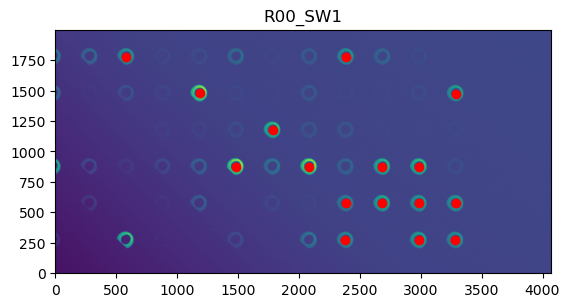

In [26]:
donCat = structDetectIntra.donutCatalog
plt.imshow(exposure_intra.image.array,origin='lower' )#vmax=200)
plt.title(exposure_intra.getDetector().getName())
plt.scatter(donCat['centroid_x'], donCat['centroid_y'],c='r')

NameError: name 'camera' is not defined

<Figure size 1000x400 with 0 Axes>

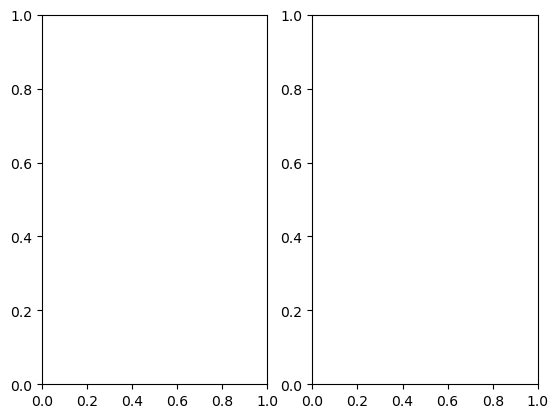

In [8]:
from lsst.ts.wep.utils import (
    DefocalType,
    createTemplateForDetector,
    getOffsetFromExposure,
    getTaskInstrument,
)

instConfigFile = 'policy:instruments/LsstCam.yaml'

fig = plt.figure(figsize=(10,4))

#rect = (left,bottom,width,height)
# this makes  
# |
# 
# 
# w =  0.2 
# ax1 = fig.add_axes((0,0.5,w,0.5))
# ax1a = fig.add_axes((w, 0.5, 2*w,0.5))
# ax1b = fig.add_axes((3*w, 0.5, 2*w,0.5))

# ax2 = fig.add_axes((0,0,w,0.5))
# ax2a = fig.add_axes((w, 0, 2*w,0.5))
# ax2b = fig.add_axes((3*w, 0, 2*w,0.5))

i = 0 

fig,ax = plt.subplots(1,2)
templates = {}
for exposure, defocalType, defocal in  zip([exposure_extra, exposure_intra],
                                  [DefocalType.Extra,DefocalType.Extra],
                                           ['extra', 'intra']
                                             
                                         ):
    camName = camera.getName()
    detectorName = exposure.getDetector().getName()
    #defocalType = DefocalType.Extra
    offset = getOffsetFromExposure(exposure, camName, defocalType)

    bandLabel = exposure.filter.bandLabel

    instrument = getTaskInstrument(
                camName,
                detectorName,
                offset,
                instConfigFile,
    )
    template = createTemplateForDetector(
            detector=exposure.detector,
            defocalType=defocalType,
            bandLabel=bandLabel,
            instrument=instrument,
            opticalModel='offAxis',
            padding=5,
            binary=True,
        )
    templates[defocal] = template
    # plot_data[i]['exposure'] = exposure
    # plot_data[i]['defocalType'] = defocalType
    # plot_data[i]['defocal'] = defocal
    # plot_data[i]['template'] = template 

    #ax[i,0].text(-70,100, 'defType \n'+defocalType.name)
                 
    #ax[i,0].imshow(template)
    ##ax[i,0].set_xticks([])
    #ax[i,0].set_yticks([])
    ax[i].imshow(template)
    ax[i].set_title(defocalType.name)
    #ax[i,1].imshow(exposure.image.array,origin='lower')
    
    
    i+=1 


#ax1.imshow(plot_data[0]['template'], origin='lower')
#ax1a.imshow(plot_data[0]['exposure'].image.array, origin='lower')
#ax1b.imshow(

Well, the actual raw templates are not identical - they're rotated by 180 deg wrt each other .... 

If we set the defocal type correctly, then templates are identical. 

But does it affect the measurement? 

The question is whether the task takes care of that ? 

In [7]:
from lsst.ts.wep.task.donutQuickMeasurementTask import ( DonutQuickMeasurementTask, DonutQuickMeasurementTaskConfig)
measurementConfig = DonutQuickMeasurementTaskConfig()
measurementTask = DonutQuickMeasurementTask(config=measurementConfig)
objData = measurementTask.run(
        exposure_extra,
        template,
        donutDiameter=np.ceil(instrument.donutDiameter).astype(int),
        cutoutPadding=5,
    )

donutDf = pd.DataFrame.from_dict(objData.detectedCatalog, orient="index")
flux = donutDf['apFlux70'].values
mag = (flux * u.nJy).to_value(u.ABmag)
xcen = 1200
ycen = 1500
w=200
fig,ax = plt.subplots(figsize=(20,10))
# [ycen-w:ycen+w,  xcen-w:xcen+w] 
plt.imshow(exposure_extra.image.array, origin='lower')
plt.scatter(donutDf['centroid_x'], donutDf['centroid_y'],c=-mag, cmap='jet') 

NameError: name 'template' is not defined

In [216]:
measurementConfig = DonutQuickMeasurementTaskConfig()
measurementTask = DonutQuickMeasurementTask(config=measurementConfig)
objData = measurementTask.run(
        exposure_intra,
        template,
        donutDiameter=np.ceil(instrument.donutDiameter).astype(int),
        cutoutPadding=5,
    )

INFO:lsst.donutQuickMeasurementTask:Found 0 sources in exposure
INFO:lsst.donutQuickMeasurementTask:Measured 0 of 0 sources in exposure


In [99]:
#measurementTask.run?

In [1]:
from scipy.signal import correlate 

In [2]:
plt.imshow(correlate(exposure_intra.image.array, templates['intra'], mode="same"), origin='lower')
plt.title(exposure_intra.detector.getName()+' intra')

NameError: name 'plt' is not defined

Text(0.5, 1.0, 'R00_SW0 extra')

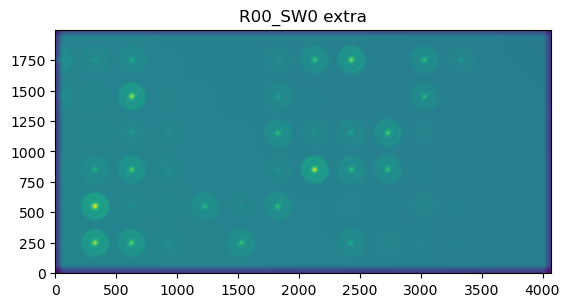

In [148]:
plt.imshow(correlate(exposure_extra.image.array, templates['extra'], mode="same"), origin='lower')
plt.title(exposure_extra.detector.getName()+' extra')

INFO:lsst.donutQuickMeasurementTask:Found 17 sources in exposure
INFO:lsst.donutQuickMeasurementTask:Measured 17 of 17 sources in exposure


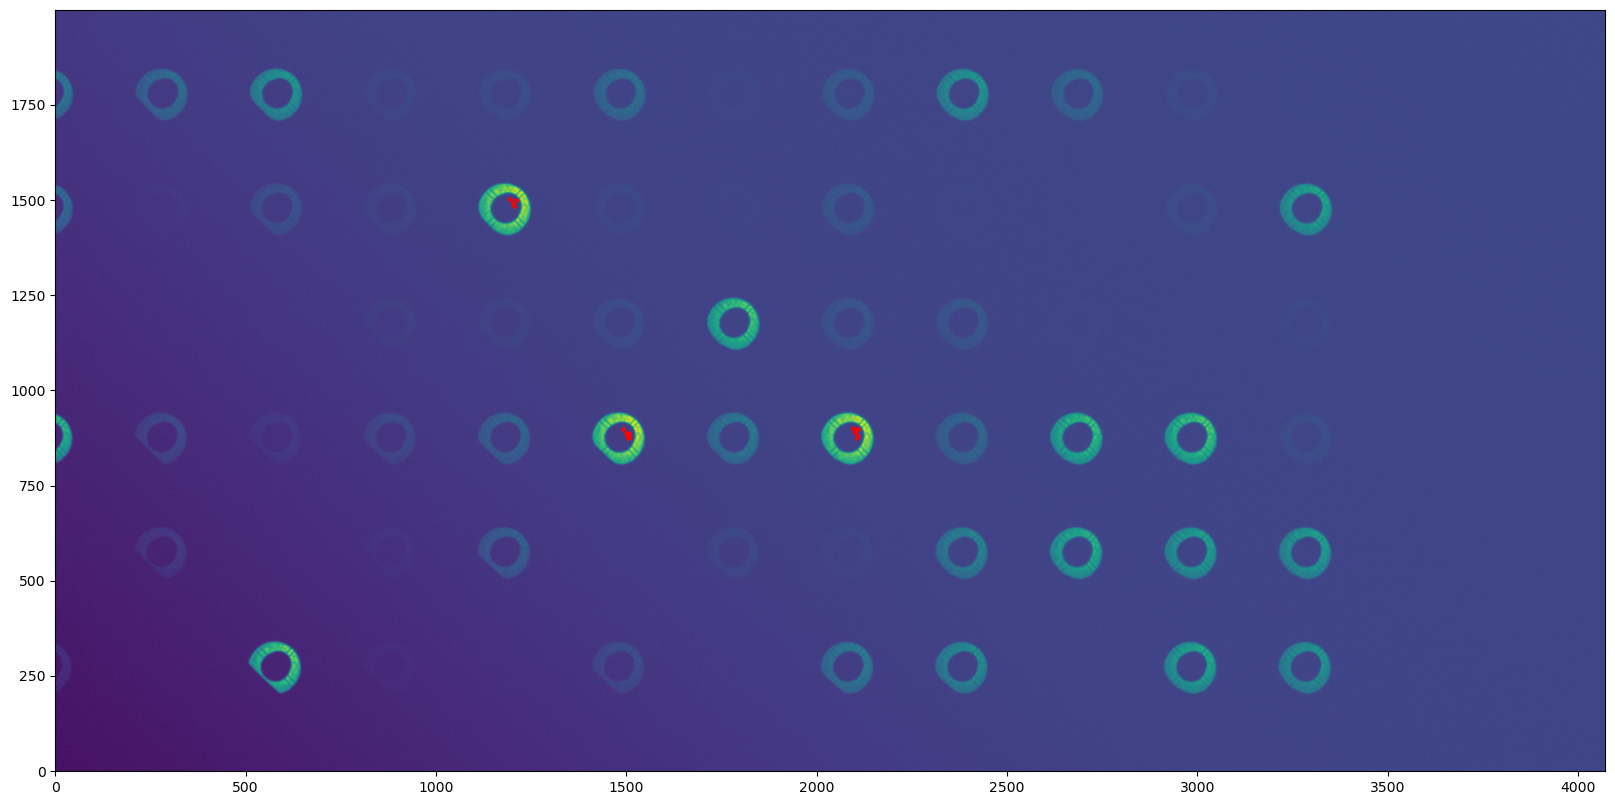

In [207]:
measurementConfig = DonutQuickMeasurementTaskConfig()
measurementConfig.doPreConvolution = False
measurementTask = DonutQuickMeasurementTask(config=measurementConfig)
objData = measurementTask.run(
        exposure_intra,
        template=template,
        donutDiameter=140,
        cutoutPadding=None,
    )
donutDf = pd.DataFrame.from_dict(objData.detectedCatalog, orient="index")
flux = donutDf['apFlux70'].values
mag = (flux * u.nJy).to_value(u.ABmag)
xcen = 1200
ycen = 1500
w=200
fig,ax = plt.subplots(figsize=(20,10))
# [ycen-w:ycen+w,  xcen-w:xcen+w] 
plt.imshow(exposure_intra.image.array, origin='lower')
plt.scatter(donutDf['centroid_x'], donutDf['centroid_y'],s=5,c='r') 

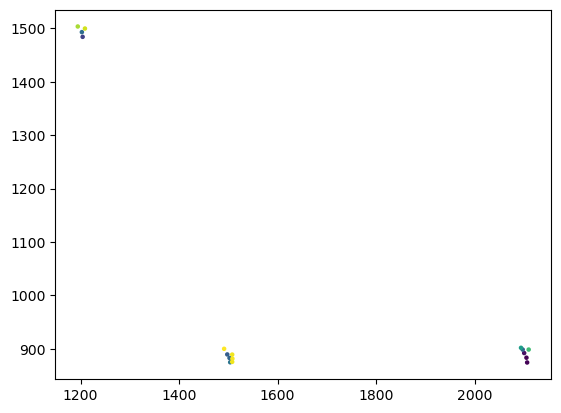

In [193]:
plt.scatter(donutDf['centroid_x'], donutDf['centroid_y'],s=5,c=mag) 

In [186]:
measurementConfig = DonutQuickMeasurementTaskConfig()
measurementConfig.doPreConvolution = True
measurementTask = DonutQuickMeasurementTask(config=measurementConfig)
objData = measurementTask.run(
        exposure_extra,
        template=template,
        donutDiameter=140,
        cutoutPadding=None,
    )

INFO:lsst.donutQuickMeasurementTask:Found 18 sources in exposure
INFO:lsst.donutQuickMeasurementTask:Measured 18 of 18 sources in exposure


In [163]:
donutDf = pd.DataFrame.from_dict(objData.detectedCatalog, orient="index")

In [166]:
flux = donutDf['apFlux70'].values

In [167]:
mag = (flux * u.nJy).to_value(u.ABmag)

In [168]:
mag

array([14.49529693, 14.41338212, 14.62199135, 14.48154283, 14.62482286,
       14.41209096, 14.62252851, 14.42214112, 14.46392766, 14.56073063,
       14.47998777, 14.53095336, 14.62741143, 14.45468264, 14.48796949,
       14.61278883, 14.59895755])

In [180]:
donutDf

xx         yy    xCentroid    yCentroid      apFlux70  \
0    3.650321   7.616676  1531.000000   878.000000  5.779380e+06   
1    4.182452   8.181160  2131.000000   877.000000  6.232283e+06   
2   11.190688  21.978455  1539.000000   887.000000  5.142845e+06   
3    5.757129   7.582644  1524.000000   899.000000  5.853059e+06   
4    8.856950  24.205480  1536.000000   898.000000  5.129451e+06   
5    5.432150   6.764411  2125.000000   898.000000  6.239699e+06   
6    7.100893  24.845408  1531.000000   907.000000  5.140302e+06   
7   13.316691  13.171815  2117.000000   909.000000  6.182207e+06   
8    4.895566   4.845611  1515.845137   907.482199  5.948794e+06   
9   38.960643  36.083465  2127.000000   915.000000  5.441364e+06   
10   7.448725   6.105408  2113.000000   918.000000  5.861448e+06   
11  42.911881  44.487745  2109.000000   925.000000  5.592663e+06   
12  24.316814   8.432910  1508.000000   927.000000  5.117236e+06   
13   6.020935   8.200524  1225.000000  1499.000000  5.999664e+06   
14  11.436800  12.483745  1220.000000  1510.000000  5.818516e+06   
15  34.198844  35.043209  1227.000000  1517.000000  5.186620e+06   
16  28.283485  36.550988  1210.000000  1528.000000  5.253116e+06   

        apFlux25   centroid_x   centroid_y  
0   1.851188e+06  1501.806669   904.468021  
1   1.856161e+06  2102.975730   881.871682  
2   1.670515e+06  1506.494451   898.032190  
3   1.730739e+06  1500.186464   892.959839  
4   1.620201e+06  1505.249724   892.779204  
5   1.736594e+06  2100.235494   885.169341  
6   1.581168e+06  1502.807031   889.026096  
7   1.734763e+06  2097.108273   887.562879  
8   1.718055e+06  1499.585651   889.466733  
9   1.564494e+06  2100.906077   889.067117  
10  1.703875e+06  2095.685680   890.230740  
11  1.634637e+06  2094.612831   892.515013  
12  1.589000e+06  1500.877170   883.191375  
13  1.706574e+06  1197.894612  1490.546984  
14  1.706516e+06  1197.700953  1490.628002  
15  1.517898e+06  1198.027318  1491.169897  
16  1.560114e+06  1197.320638  1492.272043

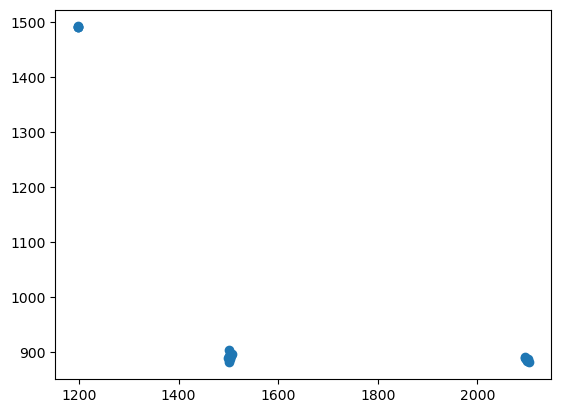

In [179]:
plt.scatter(donutDf['centroid_x'], donutDf['centroid_y']) 

donutDf

In [65]:
instrument.donutDiameter

133.02470384533996

In [78]:
import pandas as pd
donutDf = pd.DataFrame.from_dict(objData.detectedCatalog, orient="index")

In [80]:
len(donutDf)

0

In [63]:
# lets see if it makes absolutely any difference to re-instantiate the task
detectTask = GenerateDonutDirectDetectTask(config=config)
structDetectIntra = detectTask.run(exposure_intra, camera)

INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 0 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 0 of 0 sources in exposure


KeyError: 'apFlux70'

# plot the results from just one corner run with generateDirectDetect

In [31]:

from scipy.ndimage import binary_dilation


import scipy
import astropy.units as u
def calculate_entropy(stamp):
    d = stamp.stamp_im.image.array
    # these follow code from https://github.com/lsst-ts/ts_wep/blob/develop/python/lsst/ts/wep/donutImageCheck.py
    array1d = d.flatten()
    #entroThres = 3.5
    numOfBins = 256
    hist, edges = np.histogram(array1d, bins=numOfBins)
    
    # Square the distribution to magnify the difference in entropy
    imgEntropy = scipy.stats.entropy(hist**2)
    
    return imgEntropy, hist, edges, 

def calculateSN(stamp,sourceErosionIter=1, bkgDilationIter=10):
        """
        Calculate signal-to-noise ratio.

        Parameters
        ----------
        stamp : lsst.ts.wep.task.donutStamp
            A stamp containing donut image.


        Returns
        -------
        dict
             A dictionary of calculated quantities:
            'SN': the signal to noise ratio
            'signal': the calculated signal
            'noise': the calculated noise
        """

        #stamp.makeMask(instConfigFile, self.opticalModel)
        stamp_mask = stamp.stamp_im.mask.array
        image = stamp.stamp_im.image.array
        variance = stamp.stamp_im.variance.array

        donut_mask = stamp.stamp_im.mask.array > 0
    
         # Number of pixels taken by the donut in the original donut mask
        n_px_mask = np.sum(donut_mask)
    
         # Signal estimate based on the donut mean
        signal_mean = image[donut_mask].mean()  # per pixel
        ttl_signal_mean = n_px_mask * signal_mean
    
         # Signal estimate based on the sum of donut pixels
        ttl_signal_sum = np.sum(image[donut_mask])
    
         # Background noise estimate:
         # expand the inverted mask to remove donut contribution
        bkgnd_mask = ~binary_dilation(donut_mask, iterations=bkgDilationIter)
        background_image_stdev = image[bkgnd_mask].std()  # per pixel
        sqrt_mean_variance = np.sqrt(np.mean(variance[bkgnd_mask]))


     # Per-pixel variance based on the image region
         # outside of the dilated donut mask
        background_image_variance = image[bkgnd_mask].var()

         # The mean image value  in the background region
        background_image_mean = np.mean(image[bkgnd_mask])

         # Total noise based on the variance of the image background
        ttl_noise_bkgnd_variance = np.sqrt(background_image_variance * n_px_mask)

         # Noise based on the sum of variance plane pixels inside the donut mask
        ttl_noise_donut_variance = np.sqrt(variance[donut_mask].sum())
        sn = 0

        if ttl_noise_donut_variance > 0:
             sn = ttl_signal_sum / ttl_noise_donut_variance

        sn_dic = {
             "SN": sn,
             "signal_mean": ttl_signal_mean,
             "signal_sum": ttl_signal_sum,
             "n_px_mask": n_px_mask,
             "background_image_stdev": background_image_stdev,
             "sqrt_mean_variance": sqrt_mean_variance,
             "background_image_variance": background_image_variance,
             "background_image_mean": background_image_mean,
             "ttl_noise_bkgnd_variance": ttl_noise_bkgnd_variance,
             "ttl_noise_donut_variance": ttl_noise_donut_variance,
         }
        return sn_dic


In [ ]:
#summary = np.load(summary

In [32]:

from scipy.ndimage import binary_dilation
import numpy as np 
donutExtra =  results['u'][191]['donutStampsExtra'][0]
sn_dic = calculateSN(donutExtra)

In [41]:
#donutCatalogExtra

In [38]:
# run direct detect 
summary = {}
for band in results.keys():
    summary[band] = {}
    summary[band]['mag'] = []
    summary[band]['entropy'] = [] 
    
    for key in sn_dic.keys():
        summary[band][key] = []



for band in results.keys():
    for detExtra in results[band].keys() :
        
        donutStampsExtra = results[band][detExtra]['donutStampsExtra'] 
        donutCatalogExtra =  results[band][detExtra]['donutCatalogExtra']

        mag = (donutCatalogExtra['source_flux'].values * u.nJy).to_value(u.ABmag)
        donutCatalogExtra['mag'] = mag
        for i, donutExtra in enumerate(donutStampsExtra):
        
            # S/N quantities based on extra-focal donut ... 
            sn_dic = calculateSN(donutExtra)
            for key in sn_dic.keys():
                summary[band][key].append(sn_dic[key])
            
            # storing the extra-focal donut magnitude 
            summary[band]['mag'].append(donutCatalogExtra['mag'][i]) 
    
            # store the entropy 
            entr, hist, edge = calculate_entropy(donutExtra)
            summary[band]['entropy'].append(entr)
            
np.save('wfs_grid5_ugriz_dets_summary_dic_direct', summary,allow_pickle=True,)#clobber=True)




In [124]:
summary= np.load('wfs_grid5_ugriz_dets_summary_dic_direct.npy',allow_pickle=True).item()

Text(0, 0.5, 'Signal: $\\sum \\mathrm{image[donut]}$')

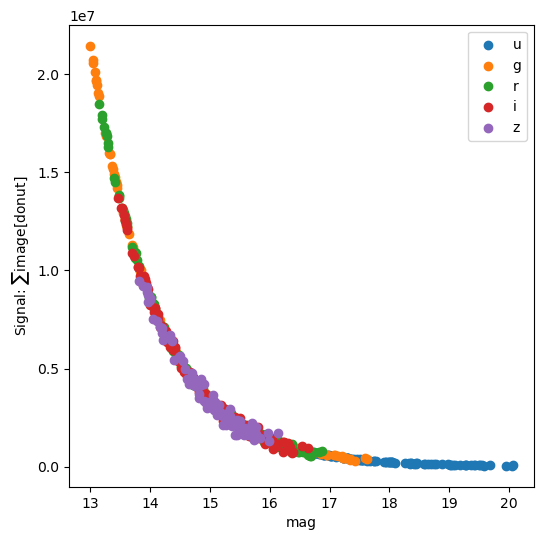

In [125]:
from matplotlib import colormaps as cmaps
import matplotlib.pyplot as plt 
from lsst.ts.wep.utils import readConfigYaml
#
#magMax = magPolicyDefaults[defaultFilterKey]["high"]

cmap = cmaps['tab10']

fig,ax = plt.subplots(1,1,figsize=(6,6))
i = 0 
for band in summary.keys() :
    ax.scatter(summary[band]['mag'], summary[band]['signal_sum'], label=band, color=cmap(i))

    #magMax = magPolicyDefaults[f'filter{band.upper()}']["high"]
    #ax.axvline(magMax, ls='--', c=cmap(i))
    i += 1 
ax.legend()
xlims = ax.get_xlim()
ax.set_xlabel('mag')
ax.set_ylabel('Signal: '+r'$\sum \mathrm{image[donut]}$')
#ax.axvline(15.90, ls='--', c='r')
#ax.axvspan(15.9, xlims[1], alpha=0.2, color='red')




Text(0, 0.5, 'Noise: $\\sqrt{\\sum \\mathrm{variance[donut]}}$')

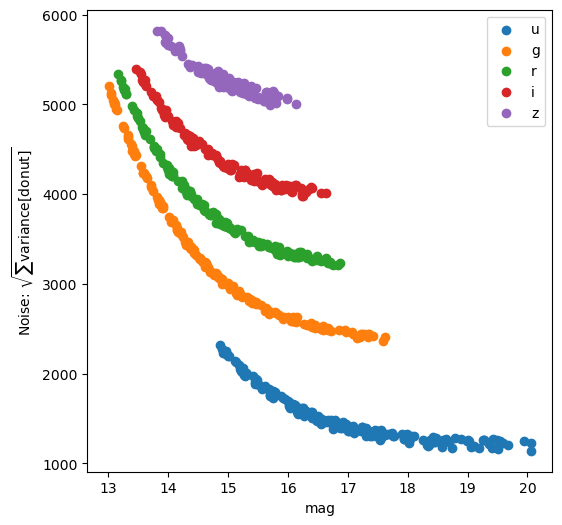

In [126]:
from matplotlib import colormaps as cmaps
import matplotlib.pyplot as plt 
from lsst.ts.wep.utils import readConfigYaml
#
#magMax = magPolicyDefaults[defaultFilterKey]["high"]

cmap = cmaps['tab10']

fig,ax = plt.subplots(1,1,figsize=(6,6))
i = 0 
for band in summary.keys() :
    ax.scatter(summary[band]['mag'], summary[band]['ttl_noise_donut_variance'], label=band, color=cmap(i))

    #magMax = magPolicyDefaults[f'filter{band.upper()}']["high"]
    #ax.axvline(magMax, ls='--', c=cmap(i))
    i += 1 
ax.legend()
xlims = ax.get_xlim()
ax.set_xlabel('mag')
ax.set_ylabel('Noise: '+r'$\sqrt{\sum \mathrm{variance[donut]}}$')
#ax.axvline(15.90, ls='--', c='r')
#ax.axvspan(15.9, xlims[1], alpha=0.2, color='red')


Text(0, 0.5, 'Noise: $\\sqrt{\\sum \\mathrm{variance[donut]}}$')

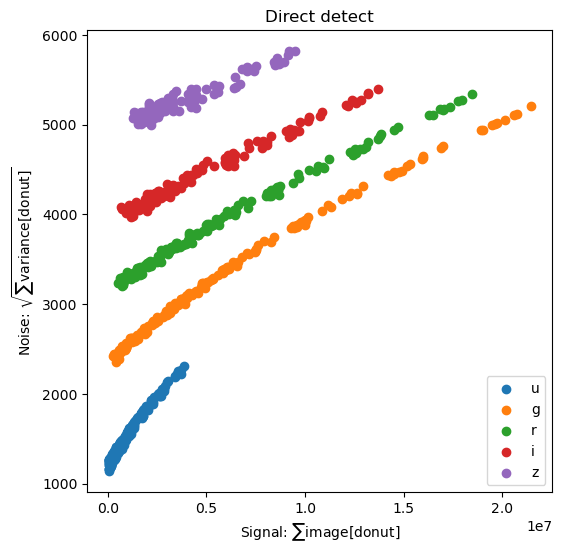

In [129]:
from matplotlib import colormaps as cmaps
import matplotlib.pyplot as plt 
from lsst.ts.wep.utils import readConfigYaml
#
#magMax = magPolicyDefaults[defaultFilterKey]["high"]

cmap = cmaps['tab10']

fig,ax = plt.subplots(1,1,figsize=(6,6))
i = 0 
for band in summary.keys() :
    ax.scatter(summary[band]['signal_sum'], summary[band]['ttl_noise_donut_variance'], label=band, color=cmap(i))

    #magMax = magPolicyDefaults[f'filter{band.upper()}']["high"]
    #ax.axvline(magMax, ls='--', c=cmap(i))
    i += 1 
ax.legend()
xlims = ax.get_xlim()
ax.set_title('Direct detect')
ax.set_xlabel('Signal: '+r'$\sum \mathrm{image[donut]}$')
ax.set_ylabel('Noise: '+r'$\sqrt{\sum \mathrm{variance[donut]}}$')
#ax.axvline(15.90, ls='--', c='r')
#ax.axvspan(15.9, xlims[1], alpha=0.2, color='red')




Text(0, 0.5, 'SN')

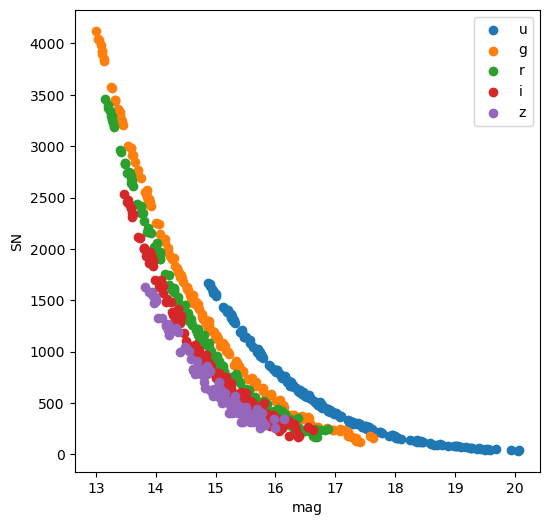

In [127]:
from matplotlib import colormaps as cmaps
import matplotlib.pyplot as plt 
from lsst.ts.wep.utils import readConfigYaml
#
#magMax = magPolicyDefaults[defaultFilterKey]["high"]

cmap = cmaps['tab10']

fig,ax = plt.subplots(1,1,figsize=(6,6))
i = 0 
for band in summary.keys() :
    ax.scatter(summary[band]['mag'], summary[band]['SN'], label=band, color=cmap(i))

    #magMax = magPolicyDefaults[f'filter{band.upper()}']["high"]
    #ax.axvline(magMax, ls='--', c=cmap(i))
    i += 1 
ax.legend()
xlims = ax.get_xlim()
ax.set_xlabel('mag')
ax.set_ylabel('SN')
#ax.axvline(15.90, ls='--', c='r')
#ax.axvspan(15.9, xlims[1], alpha=0.2, color='red')


Run the `generateDonutDirectDetect` as a pipetask. 

# Compare the `source_flux` for donuts at the same location (given that this is the source of `mag`). How do these compare? 

In [44]:
summary['u'].keys()

dict_keys(['mag', 'entropy', 'SN', 'signal_mean', 'signal_sum', 'n_px_mask', 'background_image_stdev', 'sqrt_mean_variance', 'background_image_variance', 'background_image_mean', 'ttl_noise_bkgnd_variance', 'ttl_noise_donut_variance'])

In [51]:
#band = 'u'
#results1 = np.load(f'wfs_grid5_ugriz_exposure_donuts_catalogs{band}').item()
     

In [58]:
donCatDet = results[band][detExtra]['donutCatalogExtra']
donCatWcs = data[band][detExtra]['donutCatalogExtra']

In [67]:
exposure_extra = results[band][detExtra]['exposure_extra']

Text(0.5, 1.0, 'R44_SW0 (z) ')

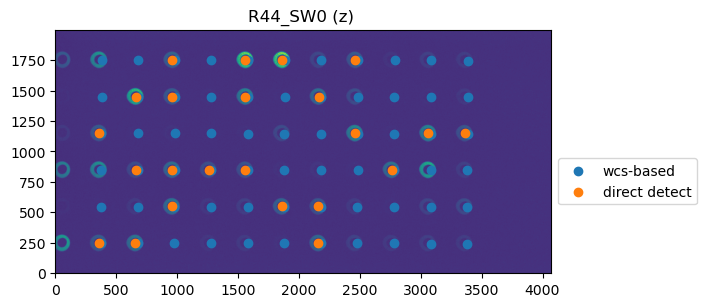

In [77]:
plt.imshow(exposure_extra.image.array, origin='lower')
plt.scatter(donCatWcs['centroid_x'], donCatWcs['centroid_y'], label='wcs-based')
plt.scatter(donCatDet['centroid_x'], donCatDet['centroid_y'], label='direct detect')
plt.legend(bbox_to_anchor=[1,0.5])
plt.title(exposure_extra.detector.getName()+f' ({exposure_extra.filter.bandLabel}) ')

Compare now only those donuts thst are both in direct-detect and wcs-based.  Try cross-matching the two catalogs:

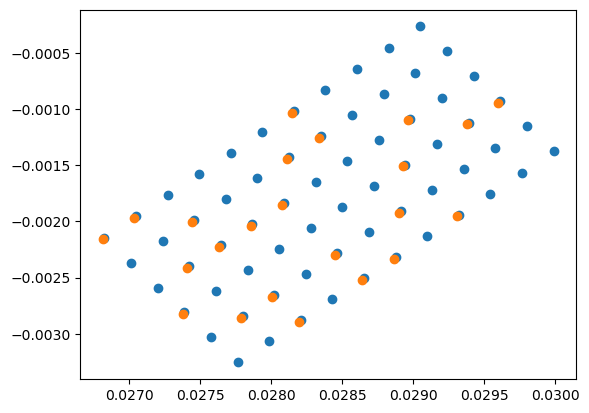

In [80]:
#plt.imshow(exposure_extra.image.array, origin='lower')
plt.scatter(donCatWcs['coord_ra'], donCatWcs['coord_dec'], label='wcs-based')
plt.scatter(donCatDet['coord_ra'], donCatDet['coord_dec'], label='direct detect')

In [90]:
donCatWcs['coord_ra'].values

array([0.02887569, 0.02865344, 0.02779902, 0.02920168, 0.02776444,
       0.02720142, 0.02894485, 0.02938935, 0.02846577, 0.02704833,
       0.02897943, 0.02745825, 0.02891027, 0.02764593, 0.02815959,
       0.02812501, 0.02820894, 0.02802127, 0.02932019, 0.0273891 ,
       0.02682608, 0.02834726, 0.0296116 , 0.02809043, 0.02786818,
       0.02913252, 0.02742368, 0.02923626, 0.02850035, 0.02909794,
       0.02901401, 0.02838184, 0.0297647 , 0.02790276, 0.02882634,
       0.02942393, 0.02998695, 0.02904859, 0.02856951, 0.02860409,
       0.02771508, 0.027236  , 0.02979927, 0.02768051, 0.02749283,
       0.02954244, 0.02853493, 0.0278336 , 0.02793734, 0.02831268,
       0.02957702, 0.02824352, 0.02879176, 0.02701375, 0.0282781 ,
       0.02875718, 0.0291671 , 0.02843119, 0.02805585, 0.02761135,
       0.02727058, 0.02935477, 0.02868802, 0.02757677, 0.02798669,
       0.0287226 ])

In [98]:
from astropy.coordinates import SkyCoord 
import astropy.units as u

c = SkyCoord(ra=donCatDet['coord_ra'].values*u.degree, 
                   dec=donCatDet['coord_dec'].values*u.degree)
catalog = SkyCoord(ra=donCatWcs['coord_ra'].values*u.degree, 
             dec=donCatWcs['coord_dec'].values*u.degree)
idx, d2d, d3d = c.match_to_catalog_sky(catalog)



In [100]:
len(c)

23

In [101]:
len(catalog)

66

ok, so there should be one match per directly detected source to the WCS-based catalog: 

In [99]:
donCatWcs.iloc[idx]

coord_ra  coord_dec   centroid_x   centroid_y   source_flux  \
0   0.028876  -0.002316  1883.289594  1747.632153  1.416797e+07   
1   0.028653  -0.002504  1582.735223  1747.962782  1.327598e+07   
2   0.027799  -0.002845   680.257636  1448.448142  1.081843e+07   
6   0.028945  -0.001497  2482.593110  1145.876446  6.727325e+06   
8   0.028466  -0.002282  1581.825485  1447.419433  6.350369e+06   
9   0.027048  -0.001956   676.708981   246.465532  5.308593e+06   
7   0.029389  -0.001121  3083.779167  1145.218284  6.555966e+06   
11  0.027458  -0.001990   978.086432   546.580691  5.138482e+06   
13  0.027646  -0.002213   978.976912   847.074821  4.755941e+06   
10  0.028979  -0.001087  2782.255905   845.007346  5.157716e+06   
12  0.028910  -0.001907  2182.937796  1446.751252  4.863817e+06   
14  0.028160  -0.001018  2179.291677   244.666254  4.312214e+06   
15  0.028125  -0.001427  1879.649982   545.516465  3.981508e+06   
20  0.026826  -0.002144   376.231768   246.835169  3.196646e+06   
16  0.028209  -0.002879   981.666767  1748.634828  3.934841e+06   
19  0.027389  -0.002810   378.874338  1148.288126  3.211905e+06   
17  0.028021  -0.002657   980.767095  1448.101696  3.262814e+06   
23  0.028090  -0.001837  1580.015568   846.372183  2.721395e+06   
21  0.028347  -0.001240  2180.198182   545.168331  2.801596e+06   
18  0.029320  -0.001941  2484.439592  1746.981617  3.242145e+06   
26  0.027424  -0.002400   678.477284   847.431243  2.113484e+06   
24  0.027868  -0.002025  1279.489609   846.721806  2.312486e+06   
22  0.029612  -0.000934  3384.393763  1144.894285  2.773242e+06   

   blend_centroid_x blend_centroid_y        mag  
0                []               []  13.521731  
1                []               []  13.592333  
2                []               []  13.814589  
6                []               []  14.330394  
8                []               []  14.393003  
9                []               []  14.587551  
7                []               []  14.358408  
11               []               []  14.622913  
13               []               []  14.706909  
10               []               []  14.618856  
12               []               []  14.682557  
14               []               []  14.813249  
15               []               []  14.899881  
20               []               []  15.138264  
16               []               []  14.912682  
19               []               []  15.133093  
17               []               []  15.116019  
23               []               []  15.313021  
21               []               []  15.281486  
18               []               []  15.122919  
26               []               []  15.587502  
24               []               []  15.489802  
22               []               []  15.292531

In [104]:
from astropy.table import join, hstack, vstack

In [138]:
#hstack?

In [139]:
from astropy.table import Table
donCatDetTable = Table.from_pandas(donCatDet)

In [140]:
donCatWcsTable = Table.from_pandas(donCatWcs)

In [141]:
donCatMerge = hstack([donCatDetTable, donCatWcsTable[idx]], table_names=['det','wcs'])

(array([2., 2., 4., 5., 4., 4., 0., 0., 1., 1.]),
 array([1.12640074, 1.20191046, 1.27742018, 1.3529299 , 1.42843962,
        1.50394934, 1.57945906, 1.65496878, 1.7304785 , 1.80598822,
        1.88149794]),
 <BarContainer object of 10 artists>)

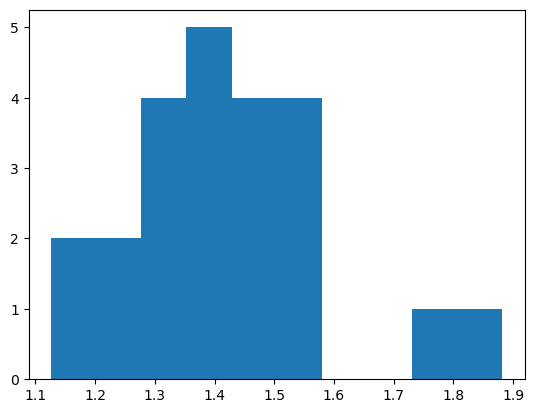

In [146]:
plt.hist(donCatMerge['source_flux_wcs'] / donCatMerge['source_flux_det'], )

ok, do that for all bands / detectors:: 

In [147]:
results[band][detExtra]

{'dataIdExtra': {'instrument': 'LSSTCam',
  'detector': 203,
  'exposure': 7023062001000,
  'visit': 7023062001000},
 'dataIdIntra': {'instrument': 'LSSTCam',
  'detector': 204,
  'exposure': 7023062001000,
  'visit': 7023062001000},
 'exposure_extra': <lsst.afw.image._exposure.ExposureF at 0x7fbfe7f23c70>,
 'exposure_intra': <lsst.afw.image._exposure.ExposureF at 0x7fbfe7e404b0>,
 'donutCatalogExtra':     coord_ra  coord_dec   centroid_x   centroid_y detector   source_flux  \
 0   0.028861  -0.002331  1861.968780  1749.851347  R44_SW0  9.588117e+06   
 1   0.028638  -0.002518  1561.068832  1748.152603  R44_SW0  9.096258e+06   
 2   0.027785  -0.002859   659.978422  1449.880183  R44_SW0  7.747871e+06   
 3   0.028930  -0.001512  2461.002595  1147.994999  R44_SW0  4.452852e+06   
 4   0.028451  -0.002296  1560.985978  1448.958590  R44_SW0  4.366236e+06   
 5   0.027035  -0.001969   657.940156   247.956797  R44_SW0  4.266927e+06   
 6   0.029375  -0.001137  3061.972895  1147.983461  R44_

In [148]:
# crossmatch donut catalog from direct detection to  WCS. Compare reported fluxes: 
for band in results.keys():
    for detExtra in results[band].keys() :

        donCatDet = results[band][detExtra]['donutCatalogExtra']
        
        donCatWcs = data[band][detExtra]['donutCatalogExtra']
        
        
        c = SkyCoord(ra=donCatDet['coord_ra'].values*u.degree, 
                           dec=donCatDet['coord_dec'].values*u.degree)
        catalog = SkyCoord(ra=donCatWcs['coord_ra'].values*u.degree, 
                     dec=donCatWcs['coord_dec'].values*u.degree)
        idx, d2d, d3d = c.match_to_catalog_sky(catalog)
        
        donCatDetTable = Table.from_pandas(donCatDet)
        donCatWcsTable = Table.from_pandas(donCatWcs)
        
        donCatMerge = hstack([donCatDetTable, donCatWcsTable[idx]], table_names=['det','wcs'])
        
        results[band][detExtra]['donutCatalogExtraMerged'] = donCatMerge

In [163]:
results[band][detExtra]['donutCatalogExtraMerged']

<Table length=23>
    coord_ra_det         coord_dec_det      ...      mag_wcs      
      float64               float64         ...      float64      
-------------------- ---------------------- ... ------------------
0.028861293144038548 -0.0023313890573174526 ... 13.521730978568582
0.028637523189344403  -0.002517771919323731 ... 13.592333174380224
0.027784896526994275 -0.0028585925997673604 ... 13.814589010216093
0.028930190234610256 -0.0015116374250851111 ... 14.330394024864663
 0.02845130288074206 -0.0022960059107610445 ...  14.39300264568061
 0.02703536426429328 -0.0019686917071428897 ... 14.587551394998284
 0.02937493598517302 -0.0011369075269254956 ... 14.358408334993722
0.027445537117622962 -0.0020041319740245925 ... 14.622912833054762
0.027632287029747987 -0.0022265652514536515 ...  14.70690876079292
 0.02896550852340898 -0.0011021452692133457 ... 14.618856418347281
                 ...                    ... ...                ...
0.026813847278477652  -0.002156516203877667 ... 15.138263675505934
0.028194450593095402  -0.002893335807340342 ... 14.912681934928859
 0.02737611826391669 -0.0028233321650974713 ... 15.133093304356105
0.028007759290837198  -0.002670930864691722 ... 15.116019288929834
 0.02807252138892825 -0.0018520389804122241 ... 15.313021210774211
 0.02833403002114379 -0.0012544786089084042 ... 15.281486357860292
0.029305677040389225  -0.001954654057329563 ... 15.122918895515474
0.027410193993278195  -0.002413681702259487 ... 15.587502417177728
0.027855108021391004    -0.0020388789980133 ... 15.489802421509482
0.029596962026222348 -0.0009498545028923251 ... 15.292530515080045

In [166]:
fluxes = {}
for band in results.keys():
    fluxes[band] = {}
    fluxes[band]['mag_det'] = []
    fluxes[band]['mag_wcs'] = []
    fluxes[band]['source_flux_det'] = []
    fluxes[band]['source_flux_wcs'] = []
    
for band in results.keys():
    fluxes[band]['mag_det'].extend(
      results[band][detExtra]['donutCatalogExtraMerged']['mag_det'].data)

    fluxes[band]['mag_wcs'].extend(
      results[band][detExtra]['donutCatalogExtraMerged']['mag_wcs'].data)

    fluxes[band]['source_flux_det'].extend(
      results[band][detExtra]['donutCatalogExtraMerged']['source_flux_det'].data)
    fluxes[band]['source_flux_wcs'].extend(
      results[band][detExtra]['donutCatalogExtraMerged']['source_flux_wcs'].data)
    

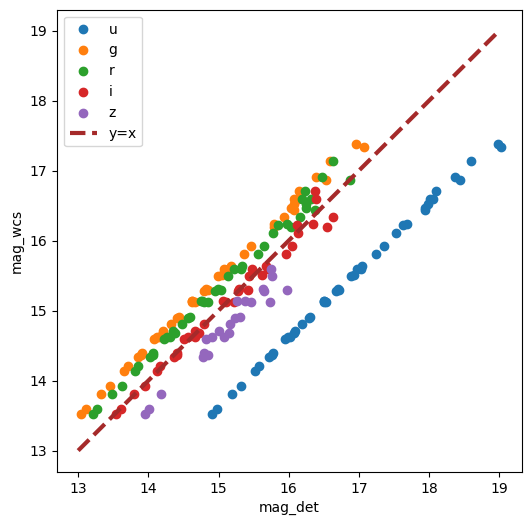

In [162]:
from matplotlib import colormaps as cmaps
import matplotlib.pyplot as plt 
from lsst.ts.wep.utils import readConfigYaml
#
#magMax = magPolicyDefaults[defaultFilterKey]["high"]

cmap = cmaps['tab10']

fig,ax = plt.subplots(1,1,figsize=(6,6))
i = 0 
for band in fluxes.keys() :
    ax.scatter(fluxes[band]['mag_det'], fluxes[band]['mag_wcs'], label=band, color=cmap(i))

    #magMax = magPolicyDefaults[f'filter{band.upper()}']["high"]
    #ax.axvline(magMax, ls='--', c=cmap(i))
    i += 1 

xlims = ax.get_xlim()
ax.set_xlabel('mag_det')
ax.set_ylabel('mag_wcs')
#ax.axvline(15.90, ls='--', c='r')
#ax.axvspan(15.9, xlims[1], alpha=0.2, color='red')
x = np.linspace(13,19)
ax.plot(x,x, c='brown',ls='--',lw=3, label='y=x')
ax.legend()

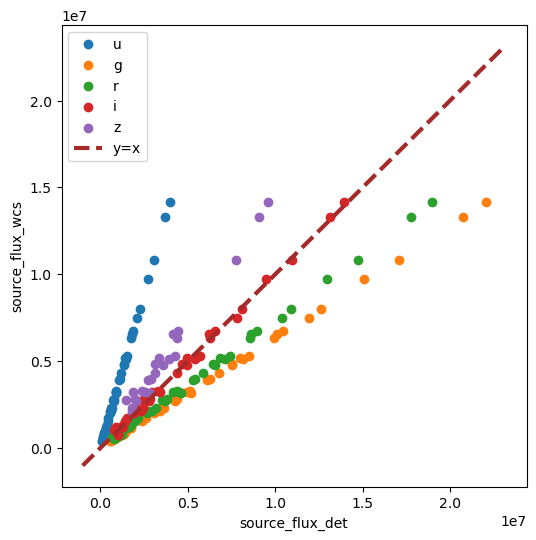

In [171]:
from matplotlib import colormaps as cmaps
import matplotlib.pyplot as plt 
from lsst.ts.wep.utils import readConfigYaml
#
#magMax = magPolicyDefaults[defaultFilterKey]["high"]

cmap = cmaps['tab10']

fig,ax = plt.subplots(1,1,figsize=(6,6))
i = 0 
for band in fluxes.keys() :
    ax.scatter(fluxes[band]['source_flux_det'], fluxes[band]['source_flux_wcs'], label=band, color=cmap(i))

    #magMax = magPolicyDefaults[f'filter{band.upper()}']["high"]
    #ax.axvline(magMax, ls='--', c=cmap(i))
    i += 1 

xlims = ax.get_xlim()
ax.set_xlabel('source_flux_det')
ax.set_ylabel('source_flux_wcs')
#ax.axvline(15.90, ls='--', c='r')
#ax.axvspan(15.9, xlims[1], alpha=0.2, color='red')
x = np.linspace(xlims[0], xlims[1])
ax.plot(x,x, c='brown',ls='--',lw=3, label='y=x')
ax.legend()

the `source_flux_det` comes from https://github.com/lsst-ts/ts_wep/blob/develop/python/lsst/ts/wep/task/donutQuickMeasurementTask.py#L107   after subtracting the median from the image.  The `source_flux_wcs` comes from https://github.com/lsst-ts/ts_wep/blob/develop/python/lsst/ts/wep/task/generateDonutCatalogWcsTask.py 